   Final Project Link: https://youtu.be/4wtfaZ8ZFac

# Perovskite Data Processing
## Section 1

   Photovoltaics, the conversion of light energy to electrical energy, is a promising technology to facilitate a worldwide transition clean energy.  Due to the need for wide scale adoption of clean energy sources to mitigate the consequences of climate change, finding and providing the most financially and energetically efficient solar cell is essential for the future of green energy.  One class of solar cells with substantial promise for consumer grade solar energy is the perovskite solar cell.  Perovskite solar cells utilize a perovskite material, having a crystal structure similar to the mineral perovskite, as their active layers.  Perovskite solar cells can be produced through much cheaper, less energy intensive methods than standard silicon solar cells, so their energy payback times are substantially shorter by comparison.  Through using the tools provided in this course, our group plans to examine several common solar cell performance metrics and attempt to unveil any new relationship between solar cell layer composition and efficiency.  The following data set was acquired through the Korea Research Institute of Chemical Technology and contains information for 2938 different solar cells.
   
   The categories present within the dataset are:
   
- Power Conversion Efficiency (PCE%) - Percentage of optical power converted into electrical power by   the solar cell
- Open Circuit Voltage (VOC) - Maximum electrical potential a solar cell can achieve
- Short Circuit Current Density (Jsc) - Maximum possible current density a solar cell can achieve
- Fill Factor (F.F.) - Ratio of the maximum power achieved by a solar cell to its maximum theoretical   power
- Cell size – Total surface area of solar cell
- Layer composition – Materials used in each layer of the solar cell
- Layer processing – Fabrication process of each layer
- Layer data – Additional layer information, primarily layer thickness.  Many entries had missing       data for this column so it was not utilized

The main indicator for efficiency of solar cells is Power Conversion Efficiency (PCE), often given as a percentage, which is the portion of the optical power fed into the cell that was converted into electrical power that leaves the cell.  The dataset also contains information on the composition and fabrication method for the layers in each device.  Some additional data is present primarily regarding layer thickness, but this column contains a substantial amount of missing data.  While we initially hoped to discover correlations between layer composition and performance metrics, the large number of different materials used for each layer among the dataset’s entries (upwards of 100 for some layers) was unsuitable for the supervised machine learning methods covered in this class.  We instead focused utilizing machine learning methods to validate the relationship between performance metrics as a proof-of-concept.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Input

from mpl_toolkits import mplot3d
from scipy import stats


'''The perovskite database from the Korea Research Institute of Chemical Technology contains information on the
layer composition and performance metrics of nearly 3,000 perovskite solar cell structures.  We intend to explore the
correlation between layer materials and solar cell performance, focusing primarily on the performance metric of 
power conversion efficiency (PCE), which is the ratio of optical power in to electrical power out.  In addition to 
analyzing the effects of individual layers on performance, we hope to be able to utilize machine learning to 
predict performance based on layer composition, or perhaps predict an optimal layer composition based on a 
desired power conversion efficiency.'''


# Below is the code that was used to extract the data from the perovskite database 
# into a dataframe and csv file.

'''
# Start by creating a dataframe from the first database entry, pd.read_html
# reads the data from the entry page's tables into a list of dataframes.
table = pd.read_html('http://www.perovskite.info/perovSearch/detail?id=1')

# The dataframe made from first table on the entry page does not have columns and values
# in the correct locations, some of the column names were input as values!  Fix by first extracting
# the data into a dictionary in the desired order
dict = {table[0][0][0]:table[0][1][0],table[0][0][1]:table[0][0][2], table[0][1][1]:table[0][1][2],
       table[0][2][1]:table[0][2][2], table[0][3][1]:table[0][3][2], table[0][4][1]:table[0][4][2],
       table[0][0][3]:table[0][1][3]}

# Then, create a dataframe from previously created dictionary
table0 = pd.DataFrame(data=dict, index=[0])

# Add the data from the next dataframe to the dataframe we just fixed, keeping all values
df = table0.join(table[1], how='right')

# All rows except for the first have NaN for their structure number value.  Redefine
# the structure number for all rows to be the value from the first row so we know which
# solar cell structure each row's information corresponds to!
n = len(df)
df.loc[:,'Structure No.'] = [df['Structure No.'][0] for i in range(n)]

# Several of the database entries have broken URLs, so we must exclude their URLs from
# the following loop in order to avoid python throwing an error!
broken = [2721, 2722, 2726, 2727, 2729, 2732, 2733, 2734, 2735, 2736, 2737, 2741, 2903, 2939]
broken.append(range(2904, 2930))

# Create dataframes from all of the other entries in the database in the same way
# as we did for the first.  Then concatenate them onto the dataframe we created earlier
# in order to get one dataframe for all entries!
for i in range(2, 2940):
    if i not in broken:
       table = pd.read_html('http://www.perovskite.info/perovSearch/detail?id=' + str(i))
       dict ={table[0][0][0]:table[0][1][0],table[0][0][1]:table[0][0][2], table[0][1][1]:table[0][1][2],
              table[0][2][1]:table[0][2][2], table[0][3][1]:table[0][3][2], table[0][4][1]:table[0][4][2],
              table[0][0][3]:table[0][1][3]}
       table0 = pd.DataFrame(data=dict, index=[0])
       sub_df = table0.join(table[1], how='right')
       n = len(sub_df)
       val1 = sub_df['Structure No.'][0]
       sub_df.loc[:,'Structure No.'] = [val1 for j in range(n)]
       df = pd.concat([df, sub_df], ignore_index=True)


# Save the final dataframe as a csv file!
df.to_csv('Perovskite_Dataset.csv')''';

In [2]:
# Read the included csv file into a dataframe
pvsk_df = pd.read_csv('full_perovskite_dataset.csv')

# When reading the csv into a dataframe, an extra index column was inserted with the 
# column name 'Unnamed: 0' since the csv file already contained a column of indices.  Let's remove it!
pvsk_df = pvsk_df.drop(columns='Unnamed: 0')

# Tin-based perovskites are currently a hot research focus for perovskites,
# as they present a non-toxic alternative to lead based perovksites
# and feature similar bandgaps!  Let's isolate entries for tin perovskites.
Sn_pvsk_list = list(pvsk_df[pvsk_df['Materials'].str.find('SnCl3') != -1]['Structure No.'])
Sn_pvsk_list.append(list(pvsk_df[pvsk_df['Materials'].str.find('SnBr3') != -1]['Structure No.']))
Sn_pvsk_list.append(list(pvsk_df[pvsk_df['Materials'].str.find('SnCl3') != -1]['Structure No.']))

# Let's ensure we are finding entries for structure that are lead-free, rather than those that contain
# both tin and lead!
noPb_pvsk_list = list(pvsk_df[pvsk_df['Materials'].str.find('Pb') == -1]['Structure No.'])
Sn_pvsk_df = pvsk_df[pvsk_df['Structure No.'].isin(Sn_pvsk_list)]
Sn_pvsk_df = Sn_pvsk_df[Sn_pvsk_df['Structure No.'].isin(noPb_pvsk_list)]
# It looks like there are only 4 entries for tin perovksites.  They are quite new,
# so that's not completely unexpected.  Likely not enough data to focus on this!

# Let's look at the structure with the highest Power Conversion Efficiency! (PCE)
max_pce_no = pvsk_df[pvsk_df['PCE(%)'] == pvsk_df['PCE(%)'].max()]['Structure No.'].values[0]
pvsk_df[pvsk_df['Structure No.'] == max_pce_no]

,Structure No.,Area(cm2),Jsc(mA/cm2),Voc(V),F.F.(%),PCE(%),Condition,Layer,Materials,Process,Data
10889,1671,0.093,24.91,1.144,0.8129,23.2,"AM 1.5G, 100mW/cm^2(Oriel ClassA 91195A/Newpor...",7,Au,Thermal evaporation,NaN
10890,1671,NaN,NaN,NaN,NaN,NaN,NaN,6,DM,Spin coating(2000rpm/30s),"DM(N2,N2′,N7,N7′-tetrakis(9,9-dimethyl-9H-fluo..."
10891,1671,NaN,NaN,NaN,NaN,NaN,NaN,5,(FAPbI3)0.95(MAPbBr3)0.05,"1-step, spin coating(1000rpm/5s, 5000rpm/20s),...",NaN
10892,1671,NaN,NaN,NaN,NaN,NaN,NaN,4,mp-TiO2,"Spin coating, calcinating at 500℃/1h",NaN
10893,1671,NaN,NaN,NaN,NaN,NaN,NaN,3,bl-TiO2,Spray pyrolysis at 450℃,NaN
10894,1671,NaN,NaN,NaN,NaN,NaN,NaN,2,FTO,(Pilkington/TEC8),NaN
10895,1671,NaN,NaN,NaN,NaN,NaN,NaN,1,Glass,NaN,NaN


In [184]:
# We didn't end up using the following code for the project but it could be an interesting
# option for future data analysis.
# There are a lot of NaN values within the dataset due to columns such as 'Layer' and 'Materials' for
# which each entry has multiple values.  Maybe at one point it will be easier to work with data that doesn't
# contain all those NaN values.  Let's test out condensing a subset of the data!

'''
# The following multi-value columns should be condensed into one list of values for each entry
condense = ['Layer', 'Materials', 'Process', 'Data']
pvsk_df100 = pvsk_df[pvsk_df['Structure No.'] == 1]

# Create a dataframe with condensed column values from the first entry
for column in condense:
    
    # If the column has a dtype other than 'object', python will throw an error when
    # trying to insert a list into a cell
    pvsk_df100[column] = pvsk_df100[column].astype('object')
    
    # Redefine the first entry from each of the specified columns to be a list of
    # all values for that entry's column.  We can still keep track of which Material, Process, etc.
    # corresponds to which layer since they will have the same list indices!
    pvsk_df100[column][0] = list(pvsk_df100[column])

# The first row now contains all of the entry's information, so let's remove the rest of the rows.
pvsk_df100 = pvsk_df100[:1]

# Repeat for the next 99 entries and concatenate into one dataframe.
for i in range(2, 101):
    pvsk_subdf = pvsk_df[pvsk_df['Structure No.'] == i].reset_index(drop=True)
    for column in condense:
        pvsk_subdf[column] = pvsk_subdf[column].astype('object')
        pvsk_subdf[column][0] = list(pvsk_subdf[column])
    pvsk_subdf = pvsk_subdf[:1]
    pvsk_df100 = pd.concat([pvsk_df100, pvsk_subdf], ignore_index=True)

# Let's see how it looks.  Each entry should only take up one row now.  
# Jupyter lab throws a bunch of warnings but it works just fine!  It seems like a lot of 
# entries don't have information for the 'Data' column so perhaps it's best not to use it for analysis.
''';

The devices within this dataset have anywhere from 4-9 layers.  Of the devices, 1445 have six layers.  In order to facilitate machine-learning and restructure the data frame into a simpler format with no missing values, we will create and utilize a sub-data frame containing only entries for devices with six layers.  In this way, layer-related columns can be split into columns for each individual layer such that all entries consist of just one row.  This will also help to ensure the function of each layer will be the same for all devices (e.g., layer 2 will be the cathode layer for all devices in the sub-dataset).

In [9]:
'''Obtain the structure numbers for only devices containing six layers
This is achieved by removing structure numbers for devices with 7 or more
layers from the set containing devices with six or more layers'''

seven_plus = set(pvsk_df[pvsk_df['Layer'] == 7]['Structure No.'])
six_plus = set(pvsk_df[pvsk_df['Layer'] == 6]['Structure No.'])
six_layers = six_plus - seven_plus

In [13]:
# Create a sub-data frame of only entries with six layers 

sixlayerdf = pvsk_df[pvsk_df['Structure No.'].isin(six_layers)]
sixlayerdf = sixlayerdf.reset_index()
sixlayerdf = sixlayerdf.drop(columns='index')
sixlayerdf.head(12)

,Structure No.,Area(cm2),Jsc(mA/cm2),Voc(V),F.F.(%),PCE(%),Condition,Layer,Materials,Process,Data
0,1,0.100,22.75,1.13,0.7501,19.3,"AM 1.5G light, 100mW/cm^2",6,Au,Thermal evaporation,thickness 100nm
1,1,NaN,NaN,NaN,NaN,NaN,NaN,5,Spiro-OMeTAD,Spin coating,thickness 200nm
2,1,NaN,NaN,NaN,NaN,NaN,NaN,4,MAPbI3-xClx,"1-step, spin coating, annealing at 90℃, 1h/100...",thickness 35nm
3,1,NaN,NaN,NaN,NaN,NaN,NaN,3,c-Y:TiO2,Annealing at 150℃/30min,thickness 40 nm
4,1,NaN,NaN,NaN,NaN,NaN,NaN,2,ITO/PEIE,"Spin coating, annealing at 100℃, 10min",NaN
5,1,NaN,NaN,NaN,NaN,NaN,NaN,1,Glass,NaN,NaN
6,6,0.096,6.80,0.68,0.5380,2.5,"AM 1.5G light, 100mW/cm^2",6,Au,Thermal evaporation,NaN
7,6,NaN,NaN,NaN,NaN,NaN,NaN,5,MAPbI3,"1-step, spin coating, heating at 100℃, 2min M...",NaN
8,6,NaN,NaN,NaN,NaN,NaN,NaN,4,mp-TiO2,"Screen printing, calcinating at 500℃, 1h, trea...",NaN
9,6,NaN,NaN,NaN,NaN,NaN,NaN,3,bl-TiO2,Spray pyrolysis,NaN


In [14]:
for i in range (6, 0, -1):
    sixlayerdf['Layer ' + str(i) + ' Material'] = [np.NaN]*len(sixlayerdf)
    sixlayerdf['Layer ' + str(i) + ' Process'] = [np.NaN]*len(sixlayerdf)

In [15]:
for i in range(0, len(sixlayerdf), 6):
        sixlayerdf['Layer 6 Material'][i] = sixlayerdf['Materials'][i]
        sixlayerdf['Layer 5 Material'][i] = sixlayerdf['Materials'][i + 1]
        sixlayerdf['Layer 4 Material'][i] = sixlayerdf['Materials'][i + 2]
        sixlayerdf['Layer 3 Material'][i] = sixlayerdf['Materials'][i + 3]
        sixlayerdf['Layer 2 Material'][i] = sixlayerdf['Materials'][i + 4]
        sixlayerdf['Layer 1 Material'][i] = sixlayerdf['Materials'][i + 5]
    
        sixlayerdf['Layer 6 Process'][i] = sixlayerdf['Process'][i]
        sixlayerdf['Layer 5 Process'][i] = sixlayerdf['Process'][i + 1]
        sixlayerdf['Layer 4 Process'][i] = sixlayerdf['Process'][i + 2]
        sixlayerdf['Layer 3 Process'][i] = sixlayerdf['Process'][i + 3]
        sixlayerdf['Layer 2 Process'][i] = sixlayerdf['Process'][i + 4]
        sixlayerdf['Layer 1 Process'][i] = sixlayerdf['Process'][i + 5]

<ipython-input-15-c4b23723cb31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sixlayerdf['Layer 6 Material'][i] = sixlayerdf['Materials'][i]
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-15-c4b23723cb31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sixlayerdf['Layer 5 Material'][i] = sixlayerdf['Ma

In [16]:
# The information from the layer, materials, process columns are now in the 
# new columns we created, so the original columns can be dropped

new_df = sixlayerdf.iloc[range(0, len(sixlayerdf), 6)].reset_index()
new_df = new_df.drop(columns=['Layer', 'Materials', 'index', 'Process', 'Condition'])

In [17]:
# Check that the new dataframe looks right
new_df

,Structure No.,Area(cm2),Jsc(mA/cm2),Voc(V),F.F.(%),PCE(%),Data,Layer 6 Material,Layer 6 Process,Layer 5 Material,Layer 5 Process,Layer 4 Material,Layer 4 Process,Layer 3 Material,Layer 3 Process,Layer 2 Material,Layer 2 Process,Layer 1 Material,Layer 1 Process
0,1,0.100,22.75,1.130,0.7501,19.30,thickness 100nm,Au,Thermal evaporation,Spiro-OMeTAD,Spin coating,MAPbI3-xClx,"1-step, spin coating, annealing at 90℃, 1h/100...",c-Y:TiO2,Annealing at 150℃/30min,ITO/PEIE,"Spin coating, annealing at 100℃, 10min",Glass,NaN
1,6,0.096,6.80,0.680,0.5380,2.50,NaN,Au,Thermal evaporation,MAPbI3,"1-step, spin coating, heating at 100℃, 2min M...",mp-TiO2,"Screen printing, calcinating at 500℃, 1h, trea...",bl-TiO2,Spray pyrolysis,FTO,NaN,Glass,NaN
2,7,0.096,1.30,0.630,0.4910,0.40,NaN,Au,Thermal evaporation,PTAA,Spin coating,MAPbI3,"1-step, spin coating, heating at 100℃, 2min M...",bl-TiO2,Spray pyrolysis,FTO,NaN,Glass,NaN
3,10,0.000,15.00,0.829,0.3420,4.26,NaN,Ag,Thermal evaporation,Spiro-OMeTAD,Spin coating,MAPbI3-xClx,"1-step, Spin coating, drying at 95℃, 2h Meter...",TiOx,"Spin coating(ethanol based solution), annealin...",ITO,NaN,PEN,NaN
4,11,0.000,5.96,0.855,0.2360,1.20,NaN,Ag,Thermal evaporation,Spiro-OMeTAD,Spin coating,MAPbI3-xClx,"1-step, Spin coating, drying at 95℃, 2h Meter...",TiOx,"Spin coating(butanol based solution), annealin...",ITO,NaN,PEN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,2881,0.060,21.44,1.050,0.6138,13.82,thickness 100 nm,Ag,Thermal evaporation,Spiro-OMeTAD,Spin coating(3000rpm/30s),MAPbI3,"2-step, Spin coating(PbI2, 5000rpm/30s), annea...",CeOx,"Spin coating(0.005M of Ce(acac)3, 4000rpm/30s)...",FTO,"Cleaning, UVO treatment for 10min",Glass,NaN
1441,2882,0.060,20.65,1.030,0.4582,9.75,thickness 100 nm,Ag,Thermal evaporation,Spiro-OMeTAD,Spin coating(3000rpm/30s),MAPbI3,"2-step, Spin coating(PbI2, 5000rpm/30s), annea...",CeOx,"Spin coating(0.02M of Ce(acac)3, 4000rpm/30s),...",FTO,"Cleaning, UVO treatment for 10min",Glass,NaN
1442,2883,0.060,20.02,1.030,0.4557,9.40,thickness 100 nm,Ag,Thermal evaporation,Spiro-OMeTAD,Spin coating(3000rpm/30s),MAPbI3,"2-step, Spin coating(PbI2, 5000rpm/30s), annea...",CeOx,"Spin coating(0.05M of Ce(acac)3, 4000rpm/30s),...",FTO,"Cleaning, UVO treatment for 10min",Glass,NaN
1443,2885,0.000,19.92,1.040,0.6634,13.74,thickness 80 nm,Au,Thermal evaporation,Spiro-OMeTAD,Spin coating(4000rpm/30s),MAPbI3,"1-step, Spin coating(5000rpm/30s), drop the CB...",TiO2,Spin coating(4000rpm/30s),ITO,Cleaning,Glass,NaN


In [191]:
new_df.to_csv('Perovskite_Dataset_6Layers_Condensed.csv')

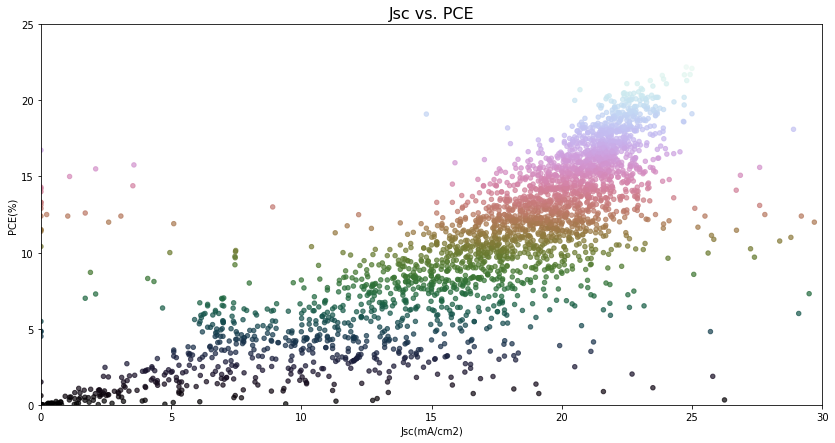

In [192]:
# Let's look at how the performance metrics short circuit current density (Jsc) and
# power conversion efficiency (PCE) correlate.

jsc_pce_df = pvsk_df[['PCE(%)', 'Jsc(mA/cm2)']].dropna()
plt.figure(figsize=(14, 7))
plt.scatter(jsc_pce_df['Jsc(mA/cm2)'], jsc_pce_df['PCE(%)'], 
            c=jsc_pce_df['PCE(%)'], cmap='cubehelix', s=20, alpha=0.7)
plt.xlabel('Jsc(mA/cm2)')
plt.ylabel('PCE(%)')
plt.title('Jsc vs. PCE', fontsize=16)
plt.xlim(0, 30)
plt.ylim(0, 25);

In [193]:
# Let's do some basic analysis of layer composition and PCE!
# Solar cells typically use either Indium Tin Oxide or Fluorine-doped Tin Oxide as a
# transparent conductive cathode layer.  Let's see how cells containing ITO vs FTO perform.

# Create a dataframe for structures using ITO as the cathode
ITO_df = pvsk_df[pvsk_df['Materials'].str.contains('ITO', na=False)]

# ITO or FTO are typically layer 2 in these perovskite solar cells, so their rows
# don't contain performance metrics.  Let's address this by getting the structure 
# numbers for these rows and using them to filter the original dataframe.
ITO_set = set(ITO_df['Structure No.'])
ITO_df = pvsk_df[pvsk_df['Structure No.'].isin(ITO_set)]

# Create a dataframe for structures using FTO as the cathode
FTO_df = pvsk_df[pvsk_df['Materials'].str.contains('FTO', na=False)]
FTO_set = set(FTO_df['Structure No.'])
FTO_df = pvsk_df[pvsk_df['Structure No.'].isin(FTO_set)]

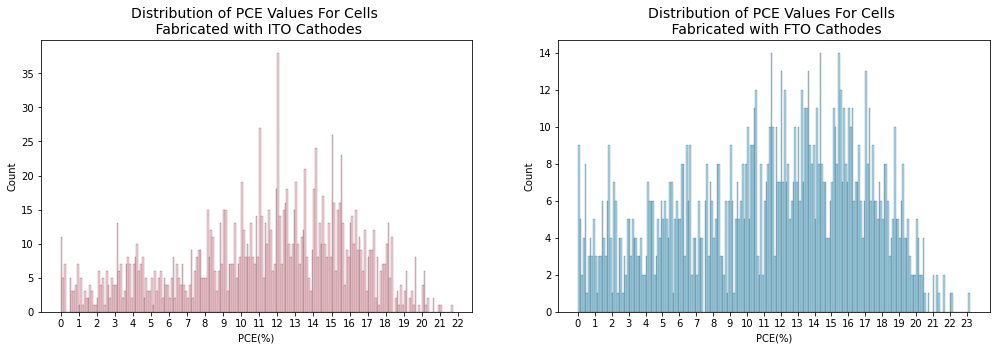

In [194]:
# Let's plot the PCE distribution for cells with ITO and FTO cathodes side by side!

plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
# PCE values differ by no less than 0.1%, so let's use 0.1 as the binwidth
sns.histplot(ITO_df['PCE(%)'], binwidth=0.1, color='pink')
plt.title('Distribution of PCE Values For Cells \n Fabricated with ITO Cathodes',
          fontsize=14)
plt.xticks(range(23))

plt.subplot(1, 2, 2)
sns.histplot(FTO_df['PCE(%)'], binwidth=0.1, color='skyblue')
plt.title('Distribution of PCE Values For Cells \n Fabricated with FTO Cathodes',
          fontsize=14)
plt.xticks(range(24));

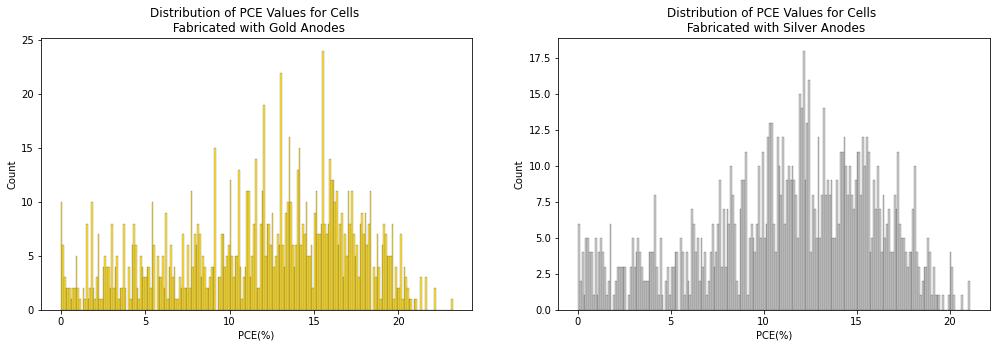

In [195]:
# Many of the cells in this database use either gold or silver as their anode layer.  Let's
# compare their performance in the same way we did above!

plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
au_df = pvsk_df[pvsk_df['Materials'].str.contains('Au')]
au_set = set(au_df['Structure No.'])
au_df = pvsk_df[pvsk_df['Structure No.'].isin(au_set)]
sns.histplot(au_df['PCE(%)'], binwidth=0.1, color='gold')
plt.title('Distribution of PCE Values for Cells \n Fabricated with Gold Anodes')

plt.subplot(1, 2, 2)
ag_df = pvsk_df[pvsk_df['Materials'].str.contains('Ag')]
sns.histplot(ag_df['PCE(%)'], binwidth=0.1, color='silver')
plt.title('Distribution of PCE Values for Cells \n Fabricated with Silver Anodes');

## Section 2

### Regression Neural Networks

Regression neural networks were used to explore the correlation between solar cell quantitative performance metrics and confirm whether machine learning algorithms can identify the relationships between them which we already know to exist.  A classification neural network was used to attempt to find a correlation between cathode layer material (either FTO or ITO) and device performance.  This method would be useful for establishing any correlation between performance metrics and other layer compositions or processing methods, given that layer composition data is categorical.  As there were far too many different layer materials (labels) in the columns, this classification method would not yield any meaningful results unless the layer data could be condensed into a manageable number of labels.

In [196]:
%matplotlib inline

In [197]:
# load in dataframe
df = pd.read_csv('Perovskite_Dataset_6Layers_Condensed.csv')
df = df.drop(columns='Unnamed: 0')

In [198]:
# F.F. is not a percentage, so rename
df = df.rename(columns={'F.F.(%)':'F.F.'})

In [199]:
# create, optimize, and train a regression neural network to
# predict PCE(%) from other performance metrics
y = df['PCE(%)'].copy()
x = df[['Voc(V)', 'Jsc(mA/cm2)', 'F.F.']].copy()

In [200]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=111)
scaler = StandardScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

In [201]:
def nnmodel1(n, learning_rate, act_func):
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(n, kernel_initializer='normal', activation=act_func))
    model.add(Dense(n, kernel_initializer='normal', activation=act_func))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=learning_rate))
    return model

In [202]:
estimator = KerasRegressor(build_fn=nnmodel1)

In [203]:
# establish hyperparameters to test for an optimal model
parameters = {'n': list(range(10, 101)), 
              'learning_rate': [0.1,0.03,0.01,0.003,0.001,0.0003,0.0001],
              'batch_size': np.arange(4,65).tolist(),
              'act_func': ['relu', 'selu']}

In [204]:
rnd_search_cv = RandomizedSearchCV(estimator=estimator, param_distributions=parameters,
                                    n_iter=20,cv=3,verbose=0,n_jobs=-1)


In [205]:
rnd_search_cv.fit(x_train_norm, y_train,verbose=0,epochs=100)

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc7a404e2e0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'act_func': ['relu', 'selu'],
                                        'batch_size': [4, 5, 6, 7, 8, 9, 10, 11,
                                                       12, 13, 14, 15, 16, 17,
                                                       18, 19, 20, 21, 22, 23,
                                                       24, 25, 26, 27, 28, 29,
                                                       30, 31, 32, 33, ...],
                                        'learning_rate': [0.1, 0.03, 0.01,
                                                          0.003, 0.001, 0.0003,
                                                          0.0001],
                                        'n': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 1

In [206]:
rnd_search_cv.best_params_

{'n': 81, 'learning_rate': 0.01, 'batch_size': 54, 'act_func': 'selu'}

In [207]:
optimal_batch = rnd_search_cv.best_params_['batch_size']

In [208]:
optimal_model = rnd_search_cv.best_estimator_.model

In [209]:
test_loss_optimal = optimal_model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss_optimal)

10/10 [==============================] - 0s 789us/step - loss: 1.0222
test set mse is 1.02


In [210]:
history = optimal_model.fit(x_train_norm, y_train, validation_split=0.2, batch_size=optimal_batch, epochs=35, verbose=0)

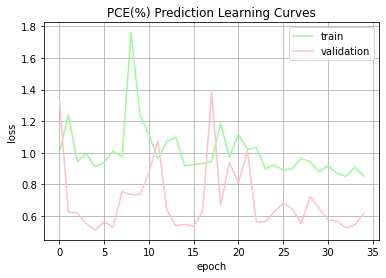

In [211]:
# plot learning curves

plt.plot(range(35), history.history['loss'], c='palegreen')
plt.plot(range(35), history.history['val_loss'], c='pink')
plt.title('PCE(%) Prediction Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

This nn appears to be able to predict PCE relatively well

In [212]:
y_test_predict = optimal_model.predict(x_test_norm)

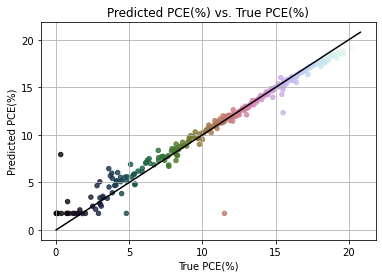

In [213]:
# plot predictions vs. true values

plt.scatter(y_test, y_test_predict, c=y_test, cmap='cubehelix', s=20, alpha=0.8)
plt.xlabel("True PCE(%)")
plt.ylabel("Predicted PCE(%)")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='k')
plt.title('Predicted PCE(%) vs. True PCE(%)')
plt.grid()

Predicted and true PCE values seem to be in good agreement

In [214]:
# create, optimize, and train a regression neural network to
# predict Voc(V) from other performance metrics

y2 = df['Voc(V)'].copy()
x2 = df[['PCE(%)', 'Jsc(mA/cm2)', 'F.F.']].copy()

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.20, random_state=111)
scaler2 = StandardScaler().fit(x_train2)
x_train_norm2 = scaler.transform(x_train2)
x_test_norm2 = scaler.transform(x_test2)

def nnmodel2(n, learning_rate, act_func):
    model = Sequential()
    model.add(Dense(3, input_dim=x_train_norm2.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(n, kernel_initializer='normal', activation=act_func))
    model.add(Dense(n, kernel_initializer='normal', activation=act_func))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=learning_rate))
    return model


estimator2 = KerasRegressor(build_fn=nnmodel2)

# test the same hyperparamter options as in the first nn

rnd_search_cv2 = RandomizedSearchCV(estimator=estimator2, param_distributions=parameters,
                                    n_iter=20,cv=3,verbose=0,n_jobs=-1)


In [215]:
rnd_search_cv2.fit(x_train_norm2, y_train2,verbose=0,epochs=100)

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc80675e340>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'act_func': ['relu', 'selu'],
                                        'batch_size': [4, 5, 6, 7, 8, 9, 10, 11,
                                                       12, 13, 14, 15, 16, 17,
                                                       18, 19, 20, 21, 22, 23,
                                                       24, 25, 26, 27, 28, 29,
                                                       30, 31, 32, 33, ...],
                                        'learning_rate': [0.1, 0.03, 0.01,
                                                          0.003, 0.001, 0.0003,
                                                          0.0001],
                                        'n': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 1

In [216]:
rnd_search_cv2.best_params_

{'n': 70, 'learning_rate': 0.001, 'batch_size': 35, 'act_func': 'selu'}

In [217]:
optimal_batch2 = rnd_search_cv2.best_params_['batch_size']
optimal_model2 = rnd_search_cv2.best_estimator_.model
test_loss_optimal2 = optimal_model2.evaluate(x_test_norm2, y_test2)
print("test set mse is %.2f" % test_loss_optimal2)

10/10 [==============================] - 0s 866us/step - loss: 0.1545
test set mse is 0.15


In [218]:
history2 = optimal_model2.fit(x_train_norm2, y_train2, validation_split=0.2, batch_size=optimal_batch2, epochs=35, verbose=0)


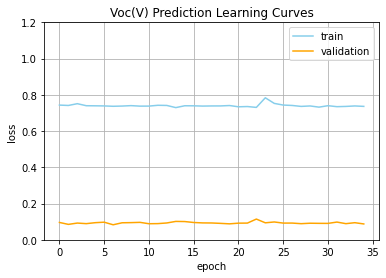

In [219]:
plt.plot(range(35), history2.history['loss'], c='skyblue')
plt.plot(range(35), history2.history['val_loss'], c='orange')
plt.title('Voc(V) Prediction Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.ylim(0, 1.2)
plt.grid()
plt.show()

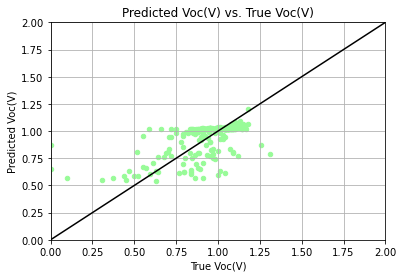

In [220]:
y_test_predict2 = optimal_model2.predict(x_test_norm2)

plt.scatter(y_test2, y_test_predict2, c='palegreen', s=20)
plt.xlabel("True Voc(V)")
plt.ylabel("Predicted Voc(V)")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title('Predicted Voc(V) vs. True Voc(V)')
plt.plot(np.arange(min(y_test2),max(y_test2),0.01),np.arange(min(y_test2),max(y_test2),0.01),c='k')
plt.grid()

This neural network's predictions don't seem to yield the best
agreement with true Voc values.  Perhaps this is a result of the narrow 
distribution of Voc

In [221]:
# create, optimize, and train a regression neural network to
# predict Jsc(mA/cm2) from other performance metrics

y3 = df['Jsc(mA/cm2)'].copy()
x3 = df[['PCE(%)', 'Voc(V)', 'F.F.']].copy()

x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.20, random_state=111)
scaler3 = StandardScaler().fit(x_train3)
x_train_norm3 = scaler.transform(x_train3)
x_test_norm3 = scaler.transform(x_test3)

def nnmodel3(n, learning_rate, act_func):
    model = Sequential()
    model.add(Dense(3, input_dim=x_train_norm3.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(n, kernel_initializer='normal', activation=act_func))
    model.add(Dense(n, kernel_initializer='normal', activation=act_func))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=learning_rate))
    return model


estimator3 = KerasRegressor(build_fn=nnmodel3) #nnmodel1 is the neural network model we defined above

# test the same paramters as in the first nn

rnd_search_cv3 = RandomizedSearchCV(estimator=estimator3, param_distributions=parameters,
                                    n_iter=20,cv=3,verbose=0,n_jobs=-1)


In [222]:
rnd_search_cv3.fit(x_train_norm3, y_train3,verbose=0,epochs=100)

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc8067bb610>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'act_func': ['relu', 'selu'],
                                        'batch_size': [4, 5, 6, 7, 8, 9, 10, 11,
                                                       12, 13, 14, 15, 16, 17,
                                                       18, 19, 20, 21, 22, 23,
                                                       24, 25, 26, 27, 28, 29,
                                                       30, 31, 32, 33, ...],
                                        'learning_rate': [0.1, 0.03, 0.01,
                                                          0.003, 0.001, 0.0003,
                                                          0.0001],
                                        'n': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 1

In [223]:
rnd_search_cv3.best_params_

{'n': 80, 'learning_rate': 0.03, 'batch_size': 15, 'act_func': 'relu'}

In [224]:
optimal_batch3 = rnd_search_cv3.best_params_['batch_size']
optimal_model3 = rnd_search_cv3.best_estimator_.model
test_loss_optimal3 = optimal_model3.evaluate(x_test_norm3, y_test3)
print("test set mse is %.2f" % test_loss_optimal3)

10/10 [==============================] - 0s 749us/step - loss: 11.8943
test set mse is 11.89


In [225]:
history3 = optimal_model3.fit(x_train_norm3, y_train3, validation_split=0.2, batch_size=optimal_batch3, epochs=35, verbose=0)


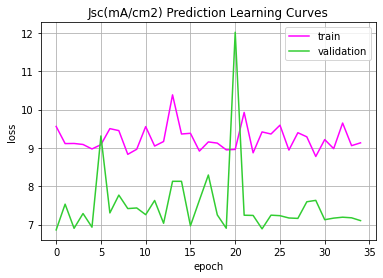

In [226]:
plt.plot(range(35), history3.history['loss'], c='fuchsia')
plt.plot(range(35), history3.history['val_loss'], c='limegreen')
plt.title('Jsc(mA/cm2) Prediction Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

It seems like a decent fit

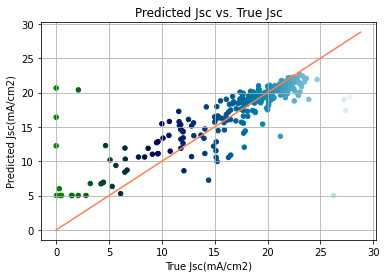

In [227]:
y_test_predict3 = optimal_model3.predict(x_test_norm3)

plt.scatter(y_test3, y_test_predict3, c=y_test3, cmap='ocean', s=20)
plt.xlabel("True Jsc(mA/cm2)")
plt.ylabel("Predicted Jsc(mA/cm2)")
plt.title('Predicted Jsc vs. True Jsc')
plt.plot(np.arange(min(y_test3),max(y_test3),0.01),np.arange(min(y_test3),max(y_test3),0.01), c='coral')
plt.grid()

In [228]:
#create, optimize, and train a regression neural network to
# predict F.F. from other performance metrics

y4 = df['F.F.'].copy()
x4 = df[['PCE(%)', 'Voc(V)', 'Jsc(mA/cm2)']].copy()

x_train4, x_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size=0.20, random_state=111)
scaler4 = StandardScaler().fit(x_train4)
x_train_norm4 = scaler.transform(x_train4)
x_test_norm4 = scaler.transform(x_test4)

def nnmodel4(n, learning_rate, act_func):
    model = Sequential()
    model.add(Dense(3, input_dim=x_train_norm3.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(n, kernel_initializer='normal', activation=act_func))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=learning_rate))
    return model


estimator4 = KerasRegressor(build_fn=nnmodel4) #nnmodel1 is the neural network model we defined above

# test same parameters as in the first nn

rnd_search_cv4 = RandomizedSearchCV(estimator=estimator4, param_distributions=parameters,
                                    n_iter=20,cv=3,verbose=0,n_jobs=-1)


In [229]:
rnd_search_cv4.fit(x_train_norm4, y_train4, verbose=0, epochs=100)

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc7304a86d0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'act_func': ['relu', 'selu'],
                                        'batch_size': [4, 5, 6, 7, 8, 9, 10, 11,
                                                       12, 13, 14, 15, 16, 17,
                                                       18, 19, 20, 21, 22, 23,
                                                       24, 25, 26, 27, 28, 29,
                                                       30, 31, 32, 33, ...],
                                        'learning_rate': [0.1, 0.03, 0.01,
                                                          0.003, 0.001, 0.0003,
                                                          0.0001],
                                        'n': [10, 11, 12, 13, 14, 15, 16, 17,
                                              18, 1

In [230]:
optimal_batch4 = rnd_search_cv4.best_params_['batch_size']
optimal_model4 = rnd_search_cv4.best_estimator_.model
test_loss_optimal4 = optimal_model4.evaluate(x_test_norm4, y_test4)
print("test set mse is %.2f" % test_loss_optimal4)

10/10 [==============================] - 0s 706us/step - loss: 0.0047
test set mse is 0.00


In [231]:
history4 = optimal_model4.fit(x_train_norm4, y_train4, validation_split=0.2, batch_size=optimal_batch4, epochs=35, verbose=0)

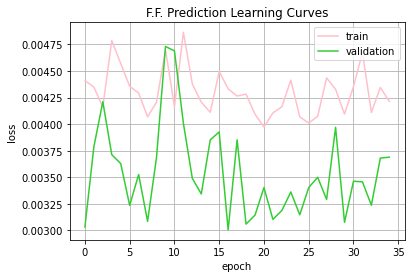

In [232]:
plt.plot(range(35), history4.history['loss'], c='pink')
plt.plot(range(35), history4.history['val_loss'], c='limegreen')
plt.title('F.F. Prediction Learning Curves')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

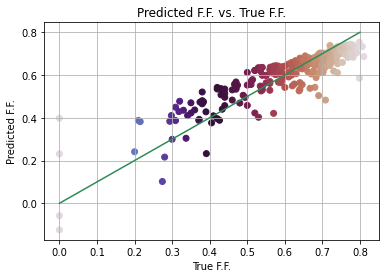

In [233]:
y_test_predict4 = optimal_model4.predict(x_test_norm4)

plt.scatter(y_test4, y_test_predict4, c=y_test4, cmap='twilight')
plt.xlabel("True F.F.")
plt.ylabel("Predicted F.F.")
plt.title('Predicted F.F. vs. True F.F.')
plt.plot(np.arange(min(y_test4),max(y_test4),0.01),np.arange(min(y_test4),max(y_test4),0.01),c='seagreen')
plt.grid()

### Classification Neural Network

In [234]:
len(df[df['Layer 2 Material'].isin(['FTO', 'ITO'])])

1379

In [235]:
# Of the 1445 entries, 1379 have either ITO or FTO as their layer
# 2 material, create a subdf from these entries
df_itofto = df[df['Layer 2 Material'].isin(['FTO', 'ITO'])]

In [236]:
# create, optimize, and train a classification neural network
# to predict layer 2 material based on performance metrics
y5 = df_itofto['Layer 2 Material'].copy()
x5 = df_itofto[['PCE(%)', 'Voc(V)', 'Jsc(mA/cm2)', 'F.F.']].copy()

labels_map = {'ITO':0,'FTO':1}
y5_int = y5.map(labels_map)

In [237]:
x_train5, x_test5, y_train5, y_test5 = train_test_split(x5, y5_int, test_size=0.2, random_state=111)
scaler5 = StandardScaler().fit(x_train5)
x_train_norm5 = scaler5.transform(x_train5)
x_test_norm5 = scaler5.transform(x_test5)

In [238]:
def binary_nn_builder(neurons, optimizer, learning_rate):
    
    model = Sequential()
    model.add(Input(shape=x_train_norm5.shape[1]))
    model.add(Dense(neurons, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(neurons, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    if optimizer=='Adam':
        optimizer = keras.optimizers.Adam(lr=learning_rate)
    elif optimizer=='SGD':
        optimizer = keras.optimizers.SGD(lr=learning_rate)
        
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

In [239]:
classifier_search = KerasClassifier(build_fn=binary_nn_builder,
                                    batch_size=32)

In [240]:
parameters5 = {
    "optimizer": ['Adam','SGD'],
    "batch_size": np.arange(4,65).tolist(),
    "learning_rate":(0.1,0.03,0.01,0.003,0.001,0.0003,0.0001),
    'neurons': list(range(10, 100))}

In [241]:
rnd_search_cv5 = RandomizedSearchCV(estimator=classifier_search,param_distributions=parameters5,n_iter=20,cv=3,verbose=0,n_jobs=-1)


In [242]:
rnd_search_cv5.fit(x_train_norm5, y_train5,verbose=0,epochs=100)

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc730328970>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'batch_size': [4, 5, 6, 7, 8, 9, 10, 11,
                                                       12, 13, 14, 15, 16, 17,
                                                       18, 19, 20, 21, 22, 23,
                                                       24, 25, 26, 27, 28, 29,
                                                       30, 31, 32, 33, ...],
                                        'learning_rate': (0.1, 0.03, 0.01,
                                                          0.003, 0.001, 0.0003,
                                                          0.0001),
                                        'neurons': [10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20, 21, 22, 23,
                                      

In [243]:
rnd_search_cv5.best_params_

{'optimizer': 'Adam', 'neurons': 60, 'learning_rate': 0.003, 'batch_size': 22}

In [244]:
optimal_model5 = rnd_search_cv5.best_estimator_.model

In [245]:
optimal_model5 = rnd_search_cv5.best_estimator_.model
test_loss_optimal5 = optimal_model5.evaluate(x_test_norm5, y_test5)
print("test set accuracy is %.4f" % test_loss_optimal5[1])

9/9 [==============================] - 0s 976us/step - loss: 0.6556 - accuracy: 0.5978
test set accuracy is 0.5978


In [246]:
history5 = optimal_model5.fit(x_train_norm5, y_train5, validation_split=0.2, epochs=1000, batch_size=47,verbose=0)

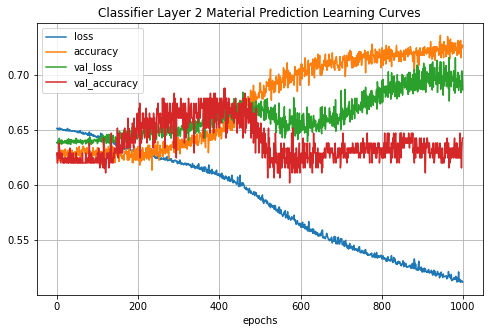

In [247]:
pd.DataFrame(history5.history).plot(figsize=(8, 5))
plt.title('Classifier Layer 2 Material Prediction Learning Curves')
plt.grid(True)
plt.gca()
plt.xlabel('epochs')
plt.show()

Based on the learning curves this model is not a good fit.  There also
may not be much of a correlation between usage of FTO or ITO and
performance.  Which material was used may very well have been a result
of a research group's budget, as FTO-coated glass is cheaper than ITO-coated
glass

### KNN Classification

KNN classification attempts to predict the class of test points by using a number of nearest neighors as reference. The distance of these neighbors is measured in order
to determine the strength of their relation to the test point in order to assign class accurately. We chose this method in the hopes that certain materials exhibit
a strong effect on the performance metrics of the resulting solar cell. For example, solar cells using gold as layer 6 material will result in highly accurate predictions
if that material results in highly clustered and consistent performance data.

In [248]:
pvsk_df = pd.read_csv('Perovskite_Dataset_6Layers_Condensed.csv')
pvsk_df = pvsk_df.drop(columns='Unnamed: 0')
pvsk_set = set(pvsk_df['Layer 6 Material'])
pvsk_set2 = set(pvsk_df['Layer 2 Material'])

#Get lengths of Sets
print(len(pvsk_set))
print(len(pvsk_set2))

23
24


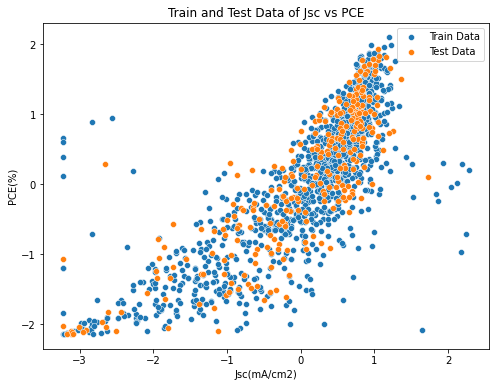

In [249]:
#collect data and split into test and train
x_knn = pvsk_df[["Jsc(mA/cm2)",'PCE(%)']].astype(float)
y_knn = pvsk_df['Layer 6 Material']

x_trainknn, x_testknn, y_trainknn, y_testknn = train_test_split(x_knn,y_knn,test_size=0.2,random_state=55)
scaler = StandardScaler().fit(x_trainknn)

x_trainknn = pd.DataFrame(data=scaler.transform(x_trainknn),columns=x_knn.columns)
x_testknn = pd.DataFrame(data=scaler.transform(x_testknn),columns=x_knn.columns)

#plot test and train data to verify
plt.figure(figsize = (8,6))
sns.scatterplot(x="Jsc(mA/cm2)",y='PCE(%)',data=x_trainknn, label="Train Data")
sns.scatterplot(x="Jsc(mA/cm2)",y='PCE(%)',data=x_testknn, label="Test Data")
plt.legend()
plt.title("Train and Test Data of Jsc vs PCE")
plt.show()


In [250]:
error_list = []

#getting optimal number of neighbors
for i in range(1,31):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(x_trainknn,y_trainknn)

    y_predictknn = knn_model.predict(x_testknn) 

    #getting error
    score = 1 - knn_model.score(x_testknn,y_testknn)
    error_list.append(score)
    
min_value = min(error_list)
min_index = error_list.index(min_value)

#applying model with optimal neighbors
knn_model = KNeighborsClassifier(n_neighbors=min_index - 1)
knn_model.fit(x_trainknn,y_trainknn)

y_predictknn = knn_model.predict(x_testknn) 

#getting final error
score = 1 - knn_model.score(x_testknn,y_testknn)
print(score)

0.5155709342560554


Circles are Train data, X's are Test data


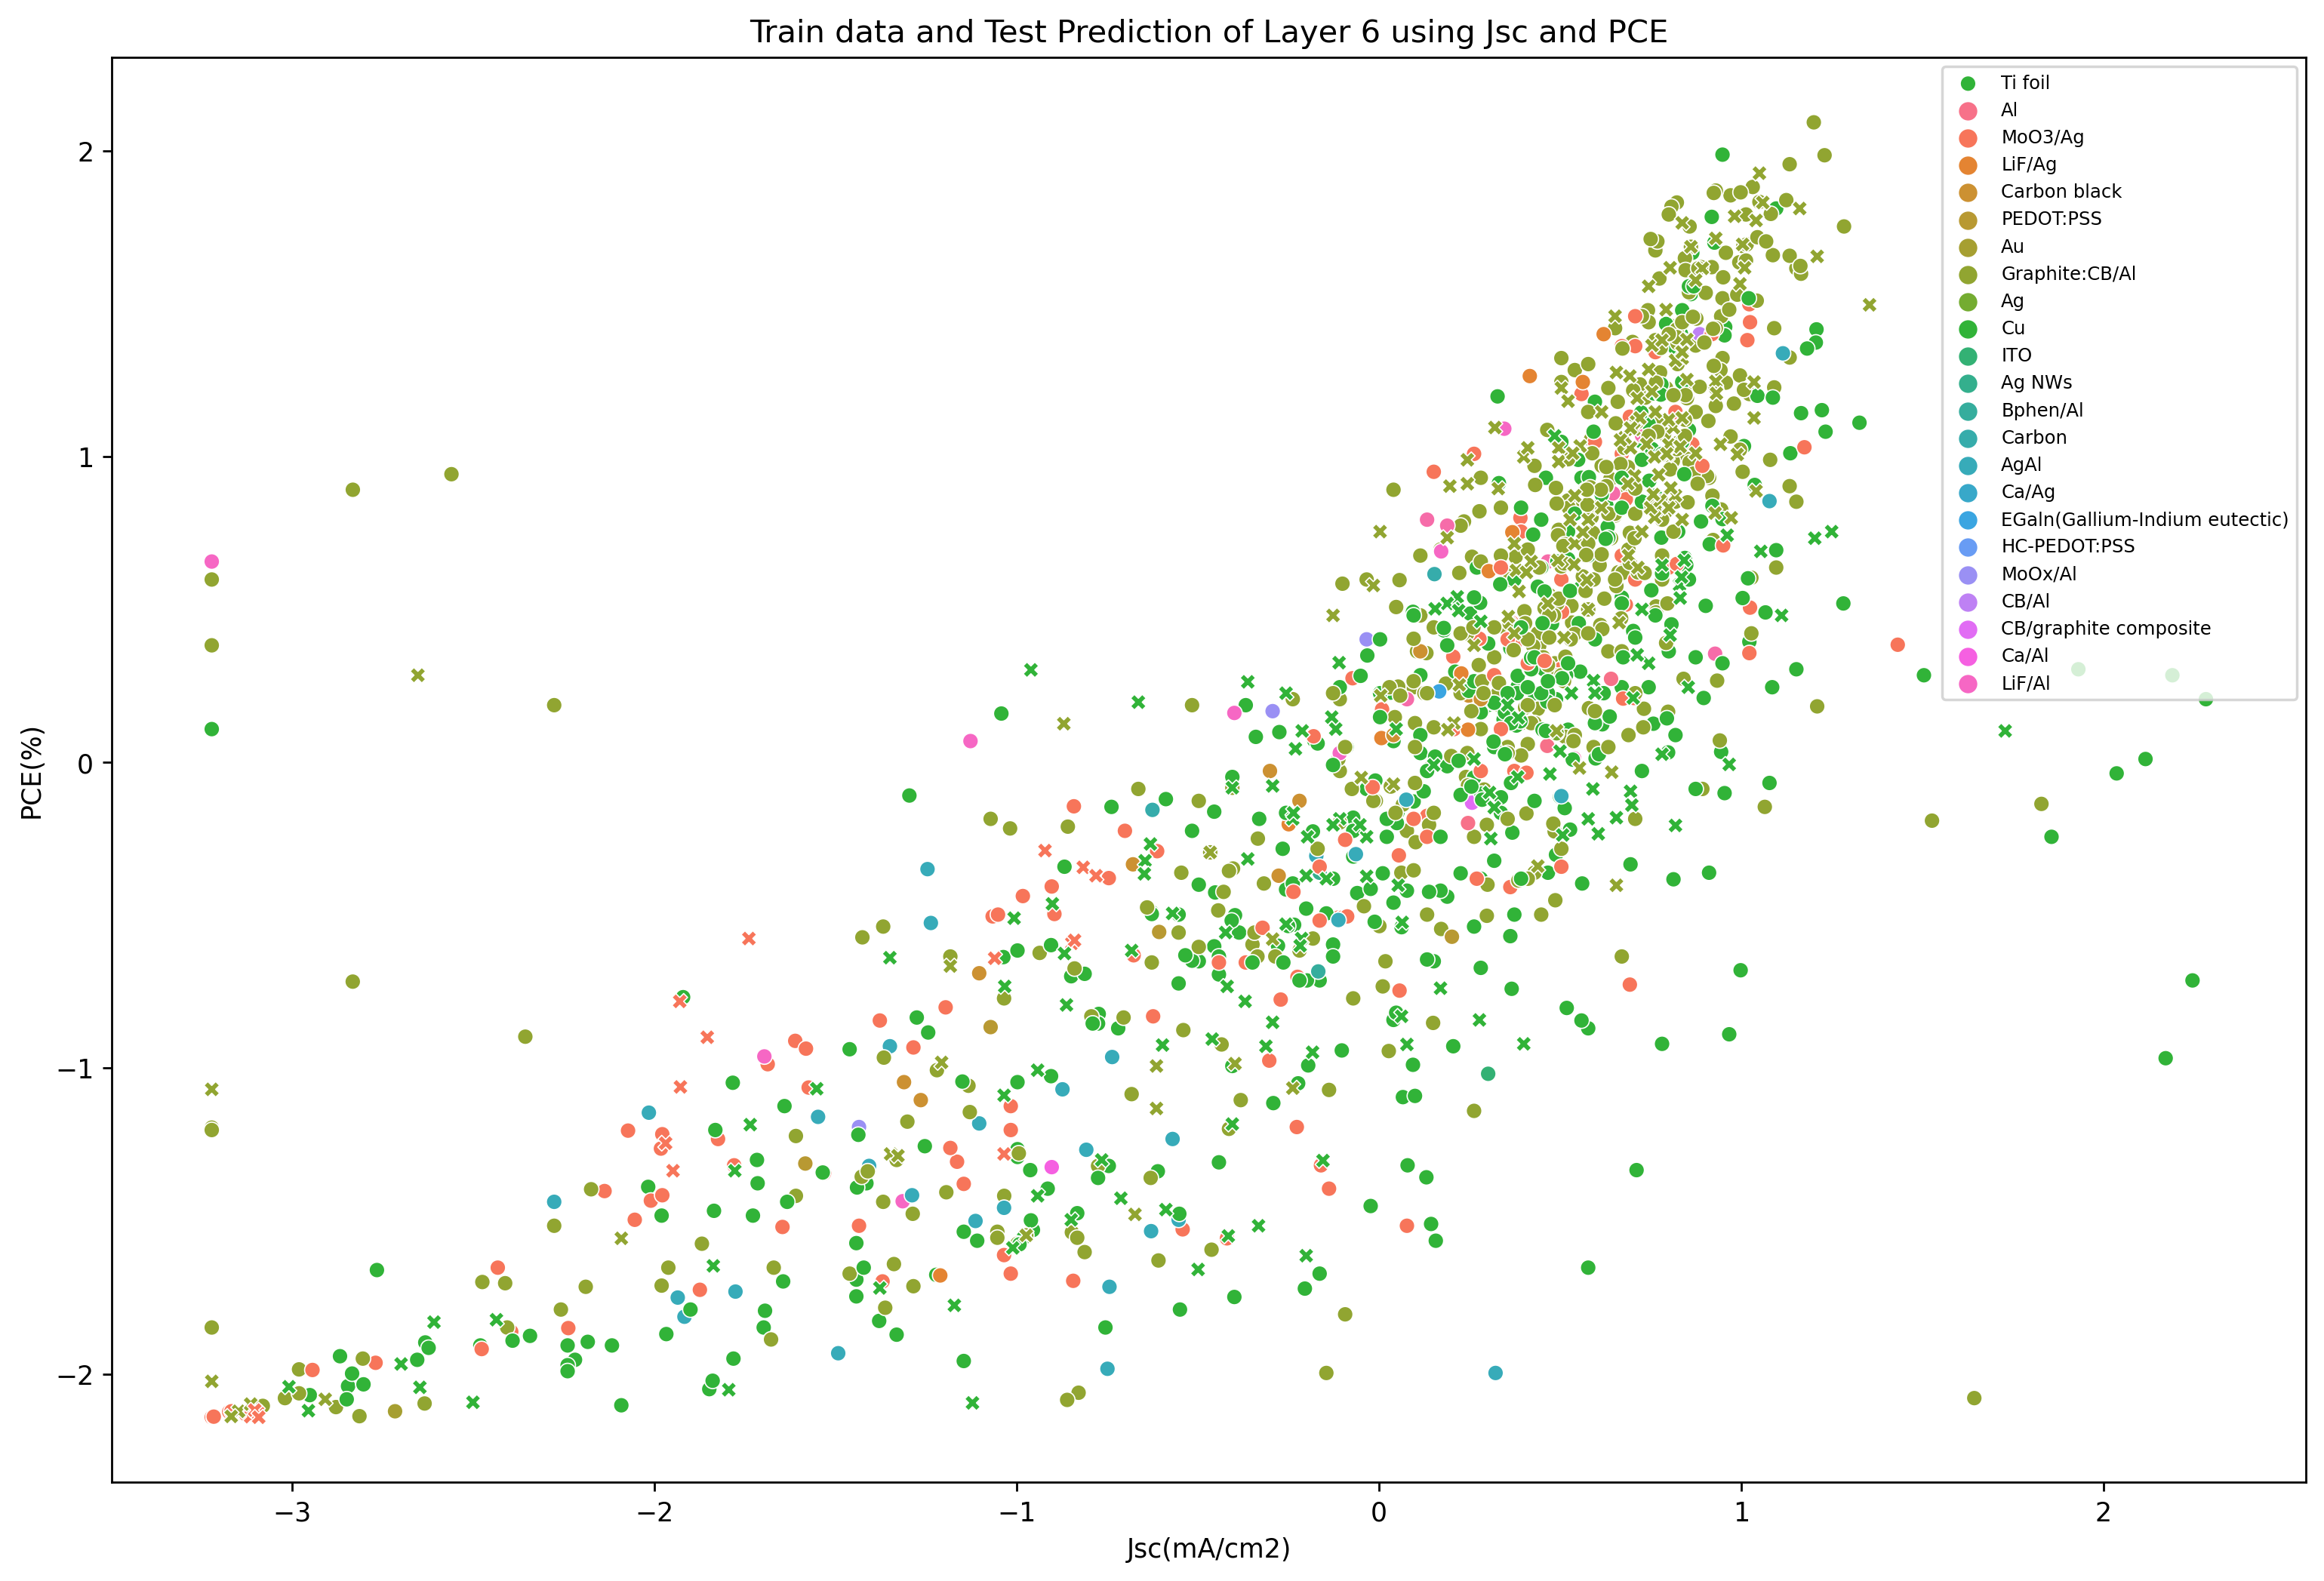

In [251]:
plt.figure(figsize=(15,10),dpi=250)

#move data to single dataframe
knnpredict_results = x_testknn.copy()
knnpredict_results['prediction'] = y_predictknn

knntrain_results = x_trainknn.copy()
knntrain_results['training data'] = y_trainknn.values 

#plot train and test data for evaluation

sns.scatterplot(x="Jsc(mA/cm2)",y='PCE(%)',data=knntrain_results,
                hue='training data',hue_order=pvsk_set)

sns.scatterplot(x="Jsc(mA/cm2)",y='PCE(%)',data=knnpredict_results,
                hue='prediction',marker='X',hue_order=pvsk_set)

plt.legend(labels=list(pvsk_set), fontsize = 7)

plt.title("Train data and Test Prediction of Layer 6 using Jsc and PCE")

print("Circles are Train data, X's are Test data")

plt.savefig("layer_6_pred")

In [252]:
# Determine Kfold test error for additional verification

kf = KFold(n_splits=4,shuffle=True,random_state=22)
test_error_kfold = 0
knn_model_evaluate = KNeighborsClassifier(n_neighbors=min_index-1)

for train_index, test_index in kf.split(x_knn):
    
    #standardization
    #fit the scaler on the train data to get the mean and standard deviation
    scaler_kfold = StandardScaler().fit(x_knn.values[train_index])
    
    #standardize the training data and testing data using the scaler
    x_train_kfold = scaler_kfold.transform(x_knn.values[train_index])
    x_test_kfold = scaler_kfold.transform(x_knn.values[test_index])
    
    y_train_kfold = y_knn[train_index]
    y_test_kfold = y_knn[test_index]
    
    knn_model_evaluate.fit(x_train_kfold,y_train_kfold)
    test_error_kfold += 1-knn_model_evaluate.score(x_test_kfold,y_test_kfold)
    
test_error_kfold /= 4

#this is the test error estimated by k-fold
test_error_kfold

0.527339266310586

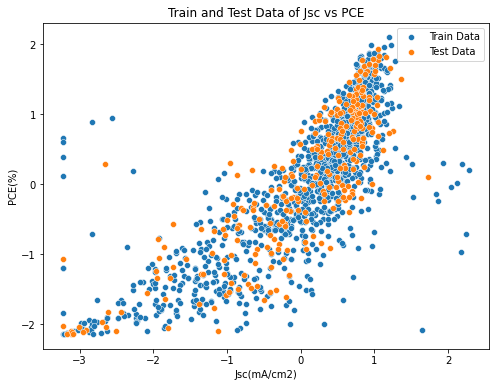

In [253]:
#Re-run for layer 2 material
x_knn = pvsk_df[["Jsc(mA/cm2)",'PCE(%)']].astype(float)
y_knn = pvsk_df['Layer 2 Material']

x_trainknn, x_testknn, y_trainknn, y_testknn = train_test_split(x_knn,y_knn,test_size=0.2,random_state=55)
scaler = StandardScaler().fit(x_trainknn)

x_trainknn = pd.DataFrame(data=scaler.transform(x_trainknn),columns=x_knn.columns)
x_testknn = pd.DataFrame(data=scaler.transform(x_testknn),columns=x_knn.columns)

#plot test and train data to verify
plt.figure(figsize = (8,6))
sns.scatterplot(x="Jsc(mA/cm2)",y='PCE(%)',data=x_trainknn, label="Train Data")
sns.scatterplot(x="Jsc(mA/cm2)",y='PCE(%)',data=x_testknn, label="Test Data")
plt.legend()
plt.title("Train and Test Data of Jsc vs PCE")
plt.show()


In [254]:
error_list = []

#getting optimal number of neighbors
for i in range(1,31):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(x_trainknn,y_trainknn)

    y_predictknn = knn_model.predict(x_testknn) 

    #getting error
    score = 1 - knn_model.score(x_testknn,y_testknn)
    error_list.append(score)
    
min_value = min(error_list)
min_index = error_list.index(min_value)

#applying model with optimal neighbors
knn_model = KNeighborsClassifier(n_neighbors=min_index - 1)
knn_model.fit(x_trainknn,y_trainknn)

y_predictknn = knn_model.predict(x_testknn) 

#getting error
score = 1 - knn_model.score(x_testknn,y_testknn)
print(score)

0.45674740484429066


Circles are Train data, X's are Test data


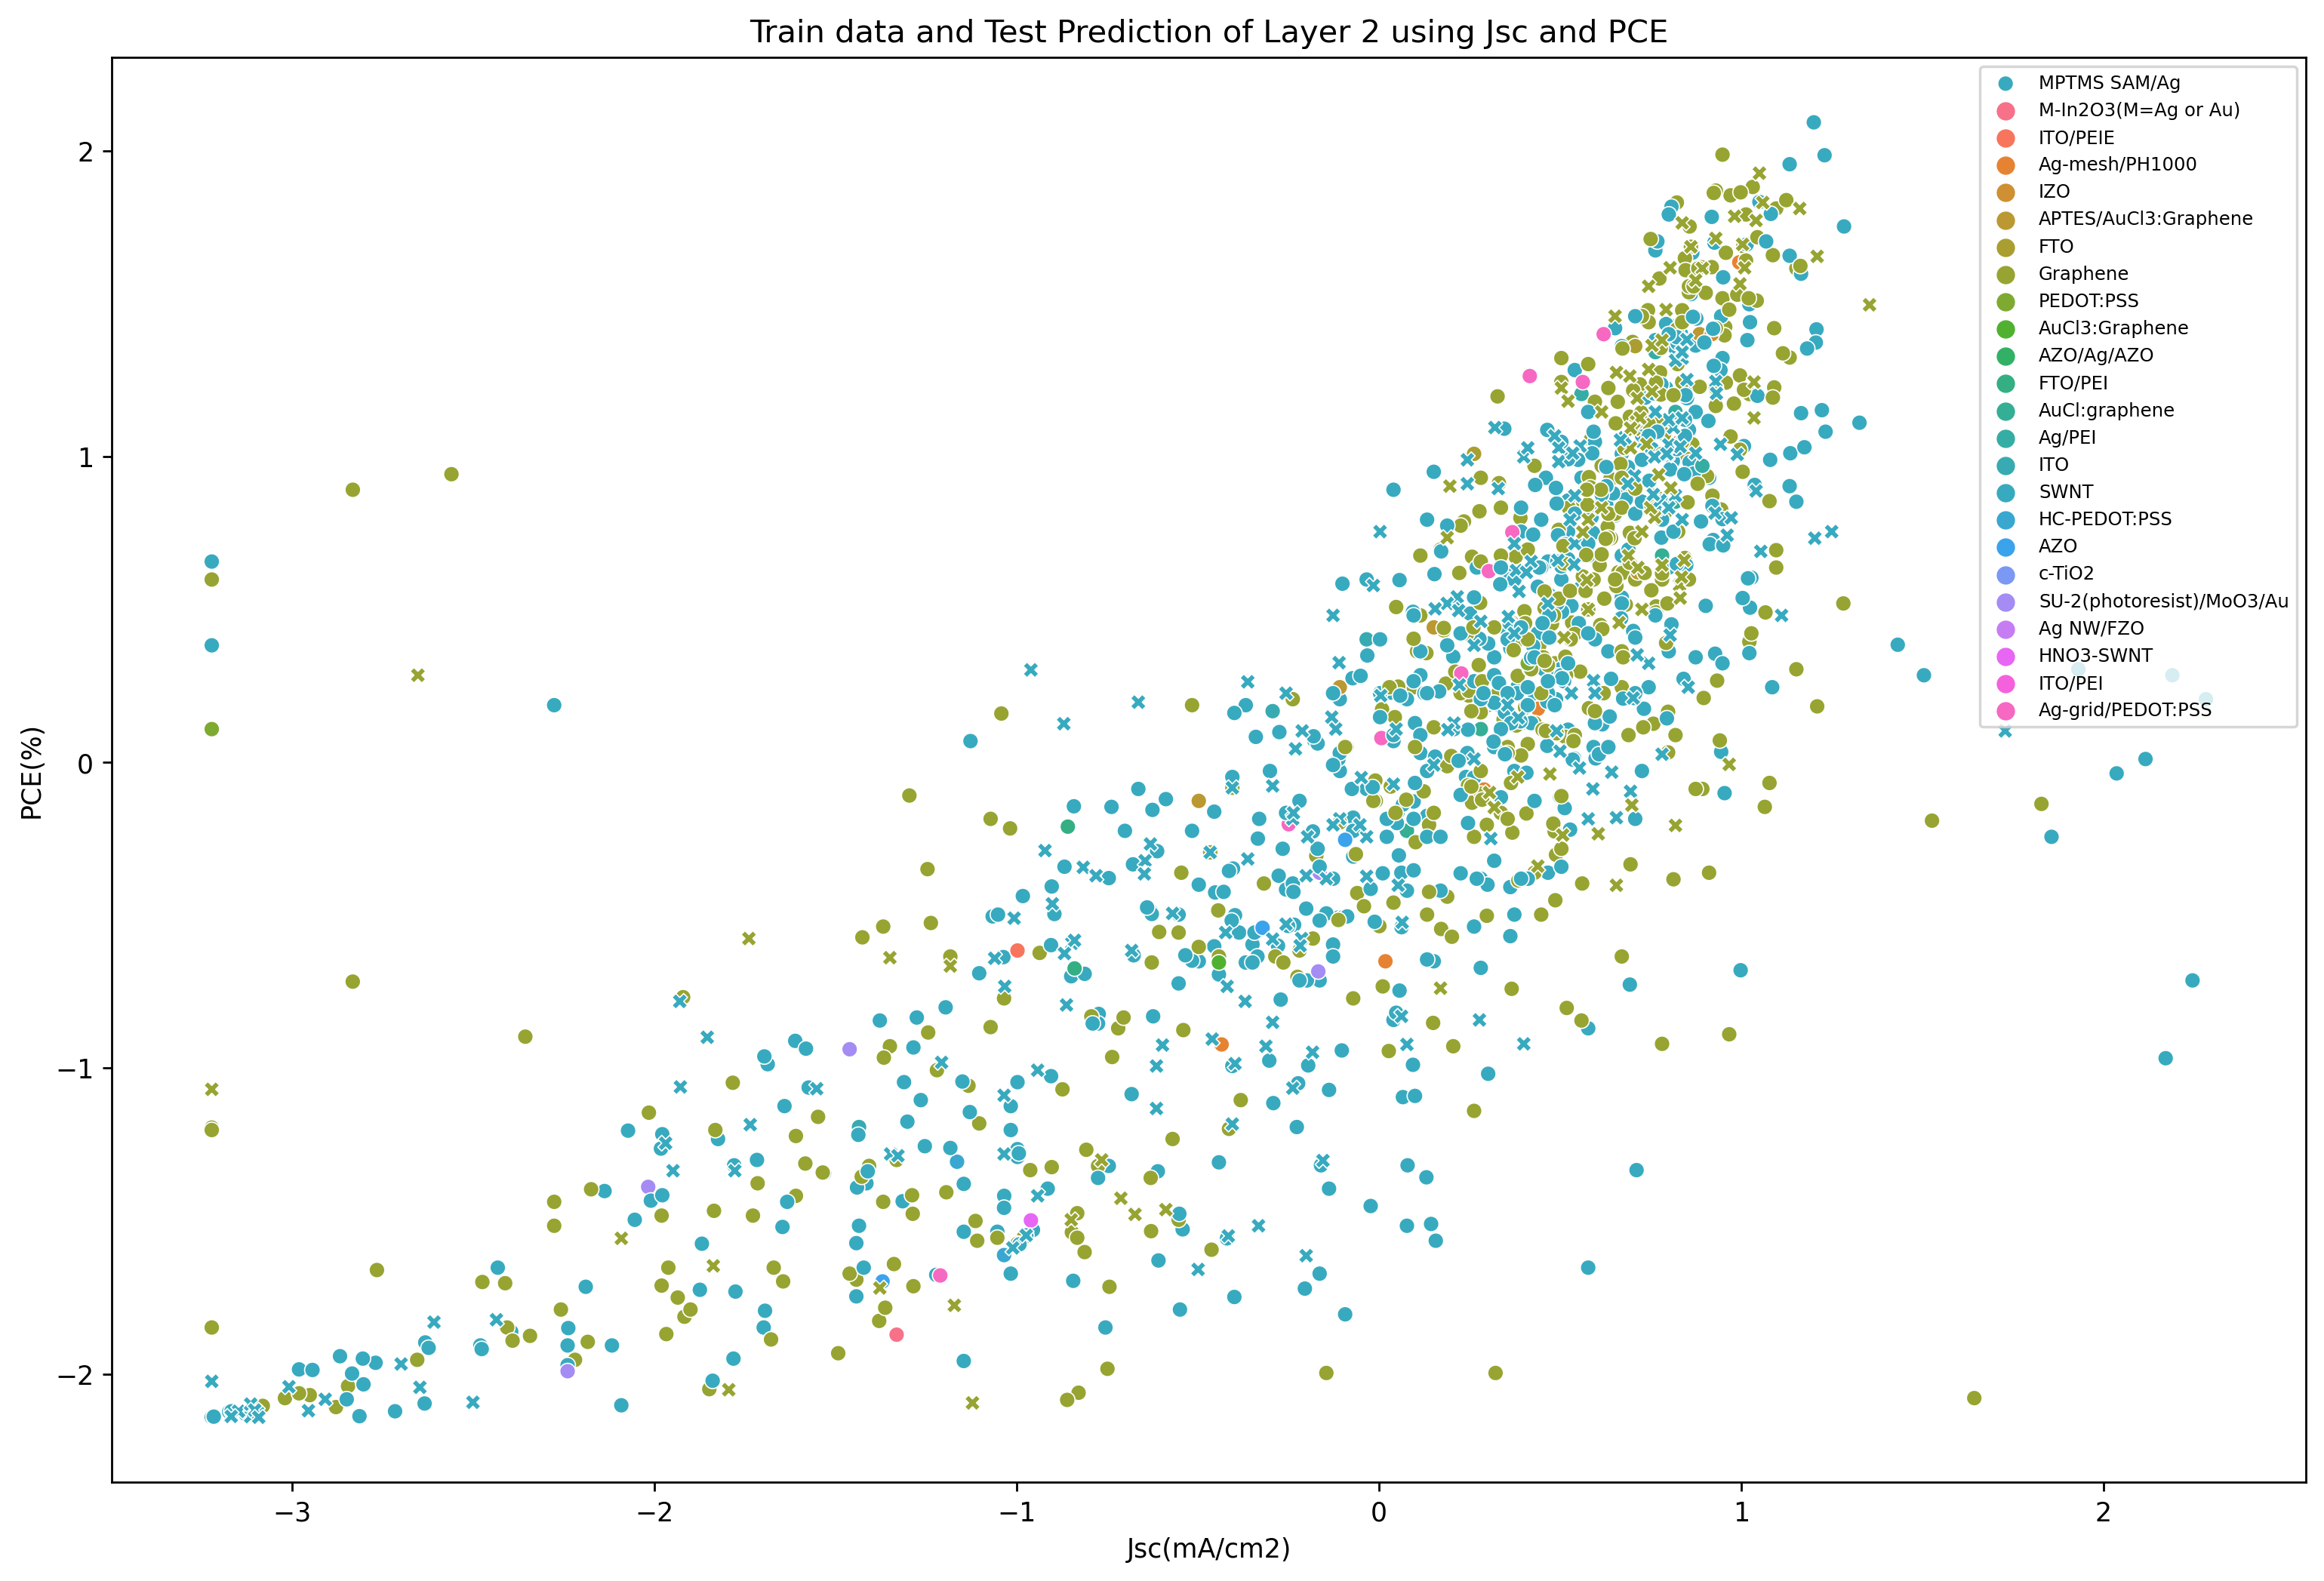

In [255]:
plt.figure(figsize=(15,10),dpi=250)

#move data to single dataframe
knnpredict_results = x_testknn.copy()
knnpredict_results['prediction'] = y_predictknn

knntrain_results = x_trainknn.copy()
knntrain_results['training data'] = y_trainknn.values 

#plot train and test data for evaluation
sns.scatterplot(x="Jsc(mA/cm2)",y='PCE(%)',data=knntrain_results,
                hue='training data',hue_order=pvsk_set2)

sns.scatterplot(x="Jsc(mA/cm2)",y='PCE(%)',data=knnpredict_results,
                hue='prediction',marker='X',hue_order=pvsk_set2)

plt.legend(labels=list(pvsk_set2), fontsize = 7)

plt.title("Train data and Test Prediction of Layer 2 using Jsc and PCE")

print("Circles are Train data, X's are Test data")

plt.savefig("layer_2_pred")

In [256]:
# Determine Kfold test error for additional verification

kf = KFold(n_splits=4,shuffle=True,random_state=22)
test_error_kfold = 0
knn_model_evaluate = KNeighborsClassifier(n_neighbors=min_index-1)

for train_index, test_index in kf.split(x_knn):
    
    #standardization
    #fit the scaler on the train data to get the mean and standard deviation
    scaler_kfold = StandardScaler().fit(x_knn.values[train_index])
    
    #standardize the training data and testing data using the scaler
    x_train_kfold = scaler_kfold.transform(x_knn.values[train_index])
    x_test_kfold = scaler_kfold.transform(x_knn.values[test_index])
    
    y_train_kfold = y_knn[train_index]
    y_test_kfold = y_knn[test_index]
    
    knn_model_evaluate.fit(x_train_kfold,y_train_kfold)
    test_error_kfold += 1-knn_model_evaluate.score(x_test_kfold,y_test_kfold)
    
test_error_kfold /= 4

#this is the test error estimated by k-fold
test_error_kfold

0.4767948148941706

### Regression

Regression utilizes a variety of models to predict the values of a desired output. In this research, linear, multilinear, and polynomial regression were used to predict the power conversion efficiency (PCE%) by using a combination of Voc, Jsc, and F.F. as independent variables. The complexity of the model increases from linear to polynomial, with the increase corresponding to more accurate mathematical models to predict trends in the dataset. We chose to use regression in order to see the correlation between the independent variables and how direct their impact on PCE% was. By using regression metrics, we hoped to see which values had the most impact on PCE%. 

Mean squared error = 9.630575403376286
R2 value = 0.6362180445639657


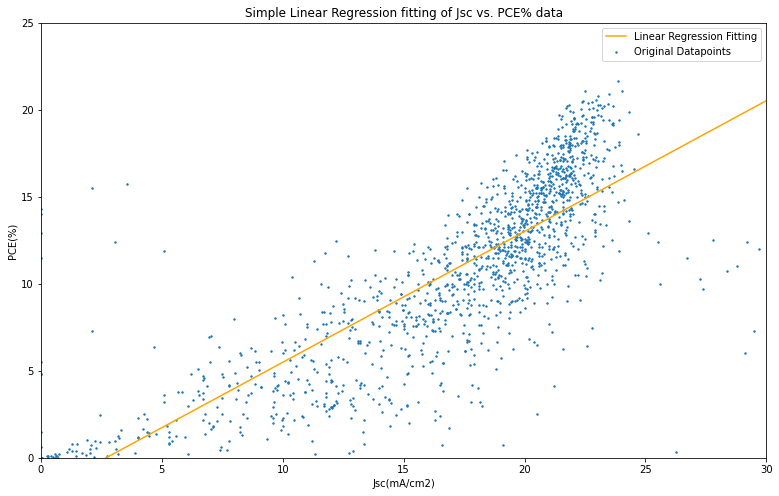

In [257]:
# Initialization of Jsc and PCE% dataset
jsc_pce_df = pvsk_df[['PCE(%)', 'Jsc(mA/cm2)']].dropna()

# Model selection and intialization of hyperparameters
model1 = linear_model.LinearRegression()

# Intialization of features and target arrays
x1 = jsc_pce_df[['Jsc(mA/cm2)']]
y1 = jsc_pce_df['PCE(%)']

# Fitting the data
model1.fit(x1,y1)
model1.coef_
model1.intercept_

# Creating predictions for new data
xfit = np.linspace(0,30)
Xfit = xfit[:, np.newaxis]
yfit = model1.predict(Xfit)

plt.figure(figsize = (13,8))
plt.scatter(x1, y1, s=2, label='Original Datapoints')
plt.plot(xfit, yfit, c='orange', label='Linear Regression Fitting');
plt.legend()
plt.xlim(0,30)
plt.ylim(0,25)
plt.title('Simple Linear Regression fitting of Jsc vs. PCE% data')
plt.ylabel('PCE(%)')
plt.xlabel('Jsc(mA/cm2)')

# Regression metrics calculation for model1
print('Mean squared error = '+str(mean_squared_error(y1, model1.predict(x1))))
print('R2 value = '+str(r2_score(y1, model1.predict(x1))))

# Average error calculation for all linear regression models
mean2_simple = 0
r2_simple = 0

mean2_simple += mean_squared_error(y1, model1.predict(x1))
r2_simple += r2_score(y1, model1.predict(x1))

Mean squared error = 9.469298177882754
R2 value = 0.6423100735445775


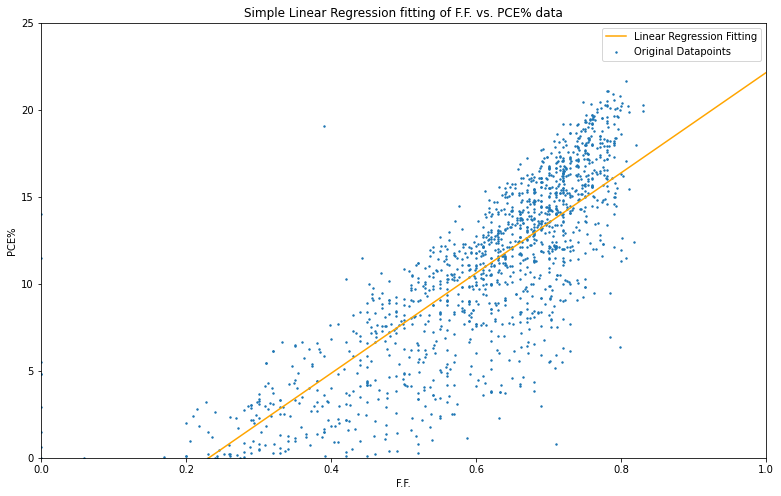

In [258]:
# Initialization of FF and PCE% dataset
ff_pce_df = pvsk_df[['PCE(%)', 'F.F.(%)']].dropna()

# Model selection and intialization of hyperparameters
model2 = linear_model.LinearRegression()
x2 = ff_pce_df[['F.F.(%)']]
y2 = ff_pce_df['PCE(%)']

# Fitting the data
model2.fit(x2,y2)
model2.coef_
model2.intercept_

# Creating predictions for new data
xfit = np.linspace(0,1)
Xfit = xfit[:, np.newaxis]
yfit = model2.predict(Xfit)

plt.figure(figsize = (13,8))
plt.scatter(x2, y2, s=2, label='Original Datapoints')
plt.plot(xfit, yfit, c='orange', label='Linear Regression Fitting');
plt.xlim(0,1)
plt.ylim(0,25)
plt.legend()
plt.title('Simple Linear Regression fitting of F.F. vs. PCE% data')
plt.ylabel('PCE%')
plt.xlabel('F.F.')

# Regression metrics calculation for model2
print('Mean squared error = '+str(mean_squared_error(y2, model2.predict(x2))))
print('R2 value = '+str(r2_score(y2, model2.predict(x2))))

# Average error calculation for all linear regression models
mean2_simple += mean_squared_error(y2, model2.predict(x2))
r2_simple += r2_score(y2, model2.predict(x2))

Mean squared error = 25.649642218528204
R2 value = 0.031119469848122083
Average mean squared error for linear models = 14.916505266595749
Average R2 value for linear models = 0.436549195985555


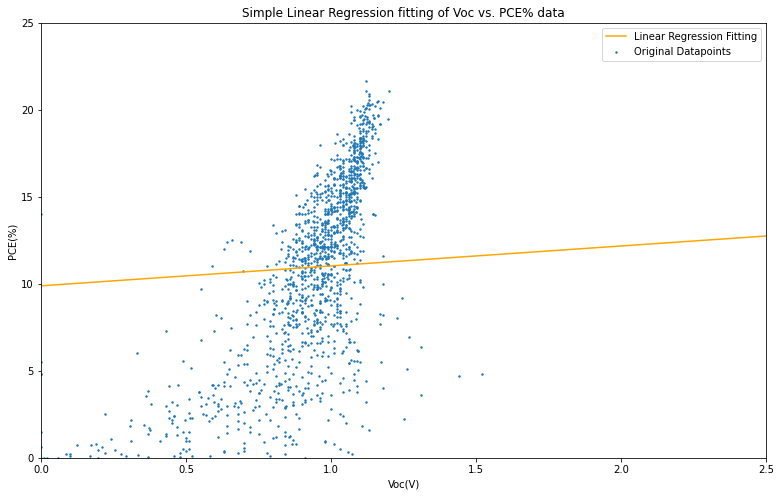

In [259]:
# Initialization of Voc and PCE% dataset
voc_pce_df = pvsk_df[['PCE(%)', 'Voc(V)']].dropna()

# Model selection and intialization of hyperparameters
model3 = linear_model.LinearRegression()
x3 = voc_pce_df[['Voc(V)']]
y3 = voc_pce_df['PCE(%)']

# Fitting the data
model3.fit(x3,y3)
model3.coef_
model3.intercept_

# Creating predictions for new data
xfit = np.linspace(0,3)
Xfit = xfit[:, np.newaxis]
yfit = model3.predict(Xfit)

plt.figure(figsize = (13,8))
plt.scatter(x3, y3, s=2, label='Original Datapoints')
plt.plot(xfit, yfit, c='orange', label='Linear Regression Fitting');
plt.ylim(0,25)
plt.xlim(0,2.5)
plt.legend()
plt.title('Simple Linear Regression fitting of Voc vs. PCE% data')
plt.ylabel('PCE(%)')
plt.xlabel('Voc(V)')

# Regression metrics calculation for model3
print('Mean squared error = '+str(mean_squared_error(y3, model3.predict(x3))))
print('R2 value = '+str(r2_score(y3, model3.predict(x3))))

# Average error calculation for all linear regression models
mean2_simple += mean_squared_error(y3, model3.predict(x3))
r2_simple += r2_score(y3, model3.predict(x3))

print('Average mean squared error for linear models = '+str(mean2_simple/3))
print('Average R2 value for linear models = '+str(r2_simple/3))

Mean squared error = 9.432961026261875
R2 value = 0.6436826602819166


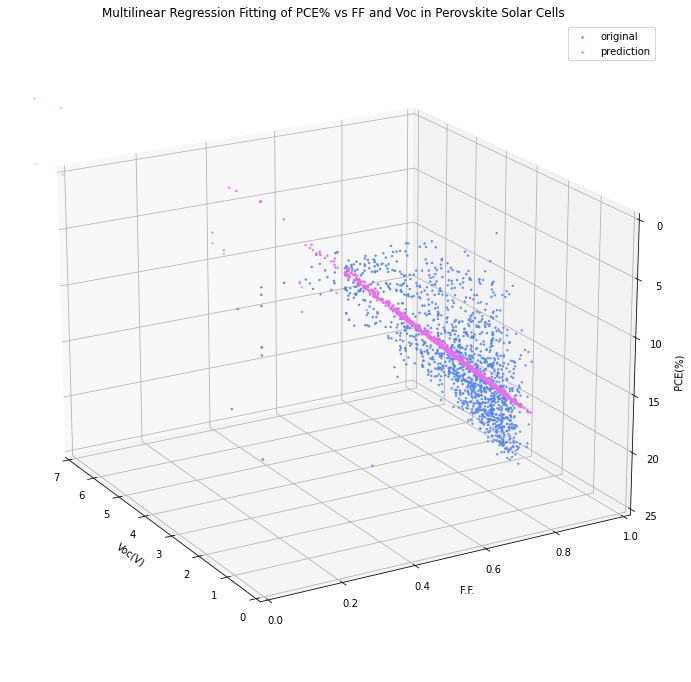

In [260]:
# Initialization of Voc/F.F. and PCE% dataset
vocff_pce_df = pvsk_df[['Voc(V)', 'F.F.(%)', 'PCE(%)']].dropna()

# Model selection and intialization of hyperparameters
model1 = linear_model.LinearRegression()

x1 = vocff_pce_df[['Voc(V)', 'F.F.(%)']]
y1 = vocff_pce_df['PCE(%)']

# Fitting the data
model1.fit(x1,y1)

plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d')
ax = plt.axes(projection='3d')

# Creating and plotting predictions for new data
plot1=ax.scatter3D(vocff_pce_df['Voc(V)'[0:6]], vocff_pce_df['F.F.(%)'], vocff_pce_df['PCE(%)'], s=2, 
                   c='#5284F2', label='original')
plot2=ax.scatter3D(vocff_pce_df['Voc(V)'[0:6]], vocff_pce_df['F.F.(%)'],
                   model1.predict(x1), c='#EA6EEA', s=2, 
                   label='prediction')

ax.view_init(200,30)
ax.set_xlabel('Voc(V)')
ax.set_ylabel('F.F.')
ax.set_zlabel('PCE(%)')
plt.xlim(0,7)
plt.ylim(0,1)
ax.set_zlim(0,25)
ax.legend()
ax.set_title('Multilinear Regression Fitting of PCE% vs FF and Voc in Perovskite Solar Cells')

# Regression metrics calculation for model1
print('Mean squared error = '+str(mean_squared_error(y1, model1.predict(x1))))
print('R2 value = '+str(r2_score(y1, model1.predict(x1))))

# Average error calculation for all multilinear regression models
mean2_multi = 0
r2_multi = 0
mean2_multi += mean_squared_error(y1, model1.predict(x1))
r2_multi += r2_score(y1, model1.predict(x1))

# Average value for Voc/F.F. predictions
vocff_r2_avg = 0
vocff_mean2_avg = 0
vocff_r2_avg += mean_squared_error(y1, model1.predict(x1))
vocff_mean2_avg += r2_score(y1, model1.predict(x1))

Mean squared error = 9.158904272855889
R2 value = 0.654034783335699


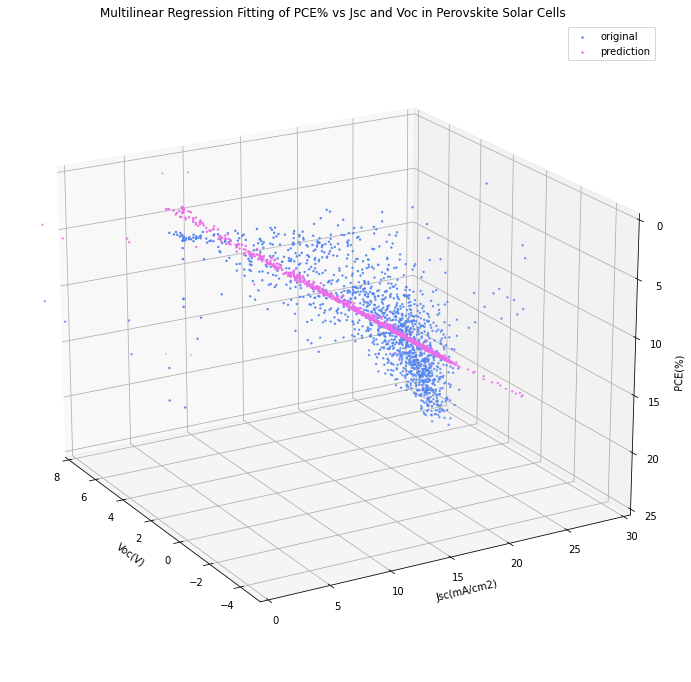

In [261]:
# Initialization of Voc/Jsc and PCE% dataset
vocjsc_pce_df = pvsk_df[['Voc(V)', 'Jsc(mA/cm2)', 'PCE(%)']].dropna()

# Model selection and intialization of hyperparameters
model2 = linear_model.LinearRegression()

x2 = vocjsc_pce_df[['Voc(V)', 'Jsc(mA/cm2)']]
y2 = vocjsc_pce_df['PCE(%)']

# Fitting the data
model2.fit(x2,y2)

plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d')
ax = plt.axes(projection='3d')

# Creating and plotting predictions for new data
plot1=ax.scatter3D(vocjsc_pce_df['Voc(V)'], vocjsc_pce_df['Jsc(mA/cm2)'[0:29]], vocjsc_pce_df['PCE(%)'], s=2, 
                   c='#5284F2', label='original')
plot2=ax.scatter3D(vocjsc_pce_df['Voc(V)'], vocjsc_pce_df['Jsc(mA/cm2)'],
                   model2.predict(x2), c='#EA6EEA', s=2, 
                   label='prediction')

ax.view_init(200,30)
ax.set_xlabel('Voc(V)')
ax.set_ylabel('Jsc(mA/cm2)')
ax.set_zlabel('PCE(%)')
plt.xlim(-5,8)
plt.ylim(0,30)
ax.set_zlim(0,25)
ax.legend()
ax.set_title('Multilinear Regression Fitting of PCE% vs Jsc and Voc in Perovskite Solar Cells')

# Regression metrics calculation for model2
print('Mean squared error = '+str(mean_squared_error(y2, model2.predict(x2))))
print('R2 value = '+str(r2_score(y2, model2.predict(x2))))

# Average error calculation for all multilinear regression models
mean2_multi += mean_squared_error(y2, model2.predict(x2))
r2_multi += r2_score(y2, model2.predict(x2))

# Average value for Voc/Jsc predictions
vocjsc_r2_avg = 0
vocjsc_mean2_avg = 0
vocjsc_r2_avg += mean_squared_error(y2, model2.predict(x2))
vocjsc_mean2_avg += r2_score(y2, model2.predict(x2))

Mean squared error = 5.130822280046561
R2 value = 0.8061901305112307
Average mean squared error for multilinear models = 7.907562526388109
Average R2 value for multilinear models = 0.7013025247096154


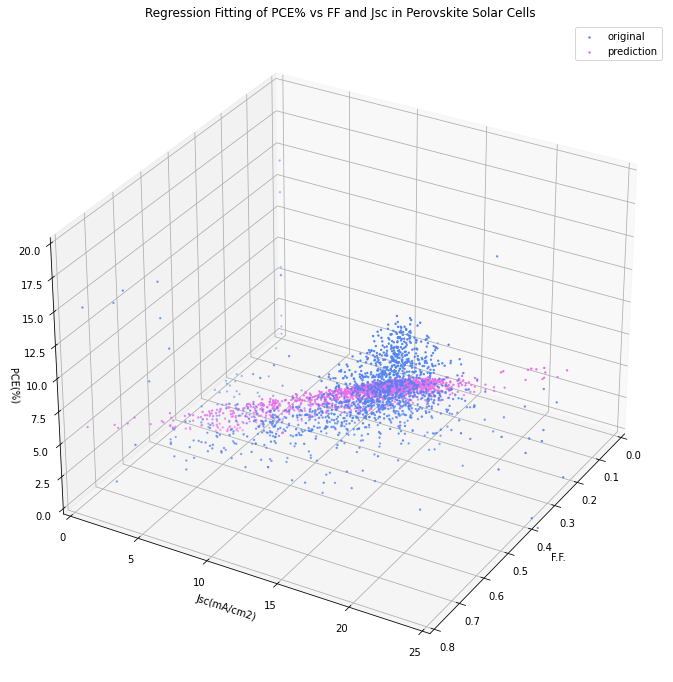

In [262]:
# Initialization of F.F./Jsc and PCE% dataset
ffjsc_pce_df = pvsk_df[['F.F.(%)', 'Jsc(mA/cm2)', 'PCE(%)']].dropna()

# Model selection and intialization of hyperparameters
model3 = linear_model.LinearRegression()

x3 = ffjsc_pce_df[['F.F.(%)', 'Jsc(mA/cm2)']]
y3 = ffjsc_pce_df['PCE(%)']

# Fitting the data
model3.fit(x3,y3)

plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d')
ax = plt.axes(projection='3d')

# Creating and plotting predictions for new data
plot1=ax.scatter3D(ffjsc_pce_df['F.F.(%)'], ffjsc_pce_df['Jsc(mA/cm2)'], ffjsc_pce_df['PCE(%)'], s=2, 
                   c='#5284F2', label='original')
plot2=ax.scatter3D(ffjsc_pce_df['F.F.(%)'], ffjsc_pce_df['Jsc(mA/cm2)'],
                   model3.predict(x3), c='#EA6EEA', s=2, 
                   label='prediction')

ax.view_init(30,30)
ax.set_xlabel('F.F.')
ax.set_ylabel('Jsc(mA/cm2)')
ax.set_zlabel('PCE(%)')
plt.xlim(0,0.8)
plt.ylim(0,25)
ax.set_zlim(0,20)
ax.legend()
ax.set_title('Regression Fitting of PCE% vs FF and Jsc in Perovskite Solar Cells')

# Regression metrics calculation for model3
print('Mean squared error = '+str(mean_squared_error(y3, model3.predict(x3))))
print('R2 value = '+str(r2_score(y3, model3.predict(x3))))

# Average error calculation for all multilinear regression models
mean2_multi += mean_squared_error(y3, model3.predict(x3))
r2_multi += r2_score(y3, model3.predict(x3))

print('Average mean squared error for multilinear models = '+str(mean2_multi/3))
print('Average R2 value for multilinear models = '+str(r2_multi/3))

# Average value for F.F./Jsc predictions
ffjsc_r2_avg = 0
ffjsc_mean2_avg = 0
ffjsc_r2_avg += mean_squared_error(y3, model3.predict(x3))
ffjsc_mean2_avg += r2_score(y3, model3.predict(x3))

Mean squared error = 6.166755086895898
R2 value = 0.7670591703773352


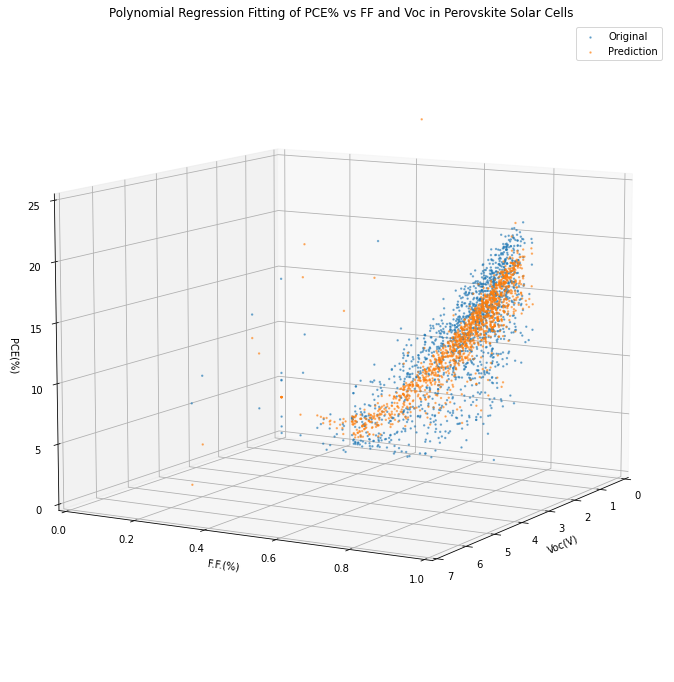

In [263]:
# Create the plot
plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d',zlim = [0,10])
plot1=ax.scatter3D(vocff_pce_df['Voc(V)'[0:6]], vocff_pce_df['F.F.(%)'], vocff_pce_df['PCE(%)'], s=2, alpha=0.5, label='Original')
ax.view_init(10,30)
ax.set_xlabel('Voc(V)')
ax.set_ylabel('F.F.(%)')
ax.set_zlabel('PCE(%)')
ax.set_title('Polynomial Regression Fitting of PCE% vs FF and Voc in Perovskite Solar Cells')
plt.xlim(0,7)
plt.ylim(0,1)
ax.set_zlim(0,25)

# Specification of hyperparameters
poly_model = make_pipeline(PolynomialFeatures(3),
                           LinearRegression())

# Fitting the data
poly_model.fit(x1, y1)

# Creating and plotting predictions for new data
plot1=ax.scatter3D(vocff_pce_df['Voc(V)'[0:6]], vocff_pce_df['F.F.(%)'], poly_model.predict(x1), s=2, alpha=0.5, label='Prediction')
ax.legend()

# Regression metrics calculation for model1
print('Mean squared error = '+str(mean_squared_error(y1, poly_model.predict(x1))))
print('R2 value = '+str(r2_score(y1, poly_model.predict(x1))))

# Average error calculation for all multilinear regression models
mean2_poly = 0
r2_poly = 0

mean2_poly += mean_squared_error(y1, poly_model.predict(x1))
r2_poly += r2_score(y1, poly_model.predict(x1))

# Average value for Voc/F.F. predictions
vocff_r2_avg += mean_squared_error(y1, poly_model.predict(x1))
vocff_mean2_avg += r2_score(y1, poly_model.predict(x1))

Mean squared error = 4.143505063150464
R2 value = 0.843484702512838


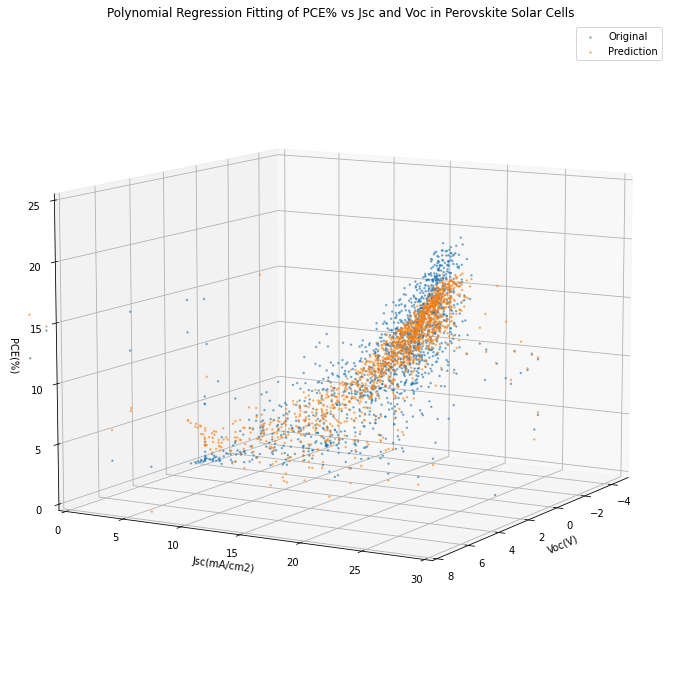

In [264]:
# Create the plot
plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d',zlim = [0,10])
plot2=ax.scatter3D(vocjsc_pce_df['Voc(V)'], vocjsc_pce_df['Jsc(mA/cm2)'[0:29]], vocjsc_pce_df['PCE(%)'], s=2, alpha=0.5, label='Original')
ax.view_init(10,30)
ax.set_xlabel('Voc(V)')
ax.set_ylabel('Jsc(mA/cm2)')
ax.set_zlabel('PCE(%)')
plt.xlim(-5,8)
plt.ylim(0,30)
ax.set_zlim(0,25)
ax.set_title('Polynomial Regression Fitting of PCE% vs Jsc and Voc in Perovskite Solar Cells')

# Specification of hyperparameters
poly_model = make_pipeline(PolynomialFeatures(3),
                           LinearRegression())

# Fitting the data
poly_model.fit(x2, y2)

# Creating and plotting predictions for new data
plot2=ax.scatter3D(vocjsc_pce_df['Voc(V)'], vocjsc_pce_df['Jsc(mA/cm2)'], poly_model.predict(x2), s=2, alpha=0.5, label='Prediction')
ax.legend()

# Regression metrics calculation for model2
print('Mean squared error = '+str(mean_squared_error(y2, poly_model.predict(x2))))
print('R2 value = '+str(r2_score(y2, poly_model.predict(x2))))

# Average error calculation for all multilinear regression models
mean2_poly += mean_squared_error(y2, poly_model.predict(x2))
r2_poly += r2_score(y2, poly_model.predict(x2))

# Average value for Voc/Jsc predictions
vocjsc_r2_avg += mean_squared_error(y2, poly_model.predict(x2))
vocjsc_mean2_avg += r2_score(y2, poly_model.predict(x2))

Mean squared error = 2.3497196058143306
R2 value = 0.9112425211239347
Average mean squared error for multilinear models = 4.2199932519535635
Average R2 value for multilinear models = 0.8405954646713694


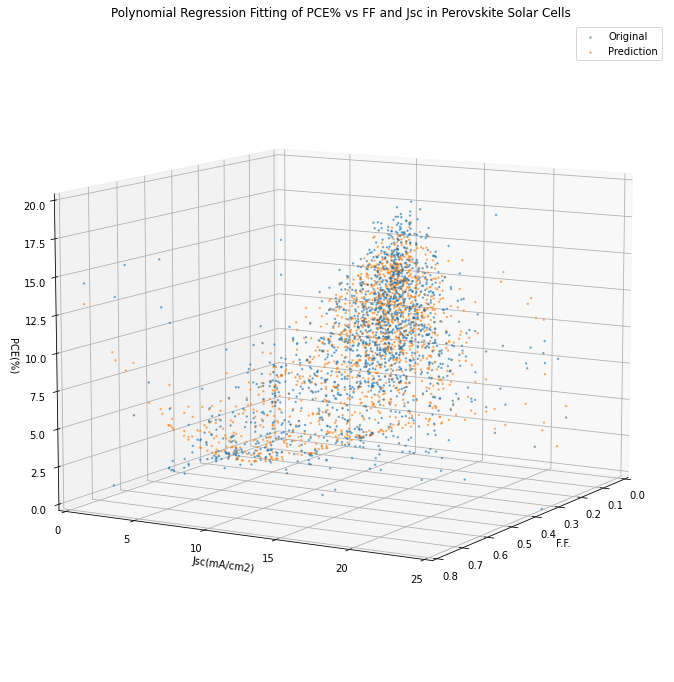

In [265]:
# Create the plot
plt.figure(figsize=(15,12))
ax = plt.axes(projection = '3d',zlim = [0,10])
plot3=ax.scatter3D(ffjsc_pce_df['F.F.(%)'], ffjsc_pce_df['Jsc(mA/cm2)'], ffjsc_pce_df['PCE(%)'], s=2, alpha=0.5, label='Original')
ax.view_init(10,30)
ax.set_xlabel('F.F.')
ax.set_ylabel('Jsc(mA/cm2)')
ax.set_zlabel('PCE(%)')
plt.xlim(0,0.8)
plt.ylim(0,25)
ax.set_zlim(0,20)
ax.set_title('Polynomial Regression Fitting of PCE% vs FF and Jsc in Perovskite Solar Cells')

# Specification of hyperparameters
poly_model = make_pipeline(PolynomialFeatures(3),
                           LinearRegression())

# Fitting the data
poly_model.fit(x3, y3)

# Creating and plotting predictions for new data
plot3=ax.scatter3D(ffjsc_pce_df['F.F.(%)'], ffjsc_pce_df['Jsc(mA/cm2)'], poly_model.predict(x3), s=2, alpha=0.5, label='Prediction')
ax.legend()

# Regression metrics calculation for model2
print('Mean squared error = '+str(mean_squared_error(y3, poly_model.predict(x3))))
print('R2 value = '+str(r2_score(y3, poly_model.predict(x3))))

# Average error calculation for all multilinear regression models
mean2_poly += mean_squared_error(y3, poly_model.predict(x3))
r2_poly += r2_score(y3, poly_model.predict(x3))

print('Average mean squared error for multilinear models = '+str(mean2_poly/3))
print('Average R2 value for multilinear models = '+str(r2_poly/3))

# Average value for F.F./Jsc predictions
ffjsc_r2_avg += mean_squared_error(y3, poly_model.predict(x3))
ffjsc_mean2_avg += r2_score(y3, poly_model.predict(x3))

In [266]:
print('Avg r2 value for Voc/F.F. = '+str(vocff_r2_avg/2))
print('Avg r2 value for Voc/Jsc = '+str(vocjsc_r2_avg/2))
print('Avg r2 value for F.F./Jsc = '+str(ffjsc_r2_avg/2))
print('Avg mean squared error value for Voc/F.F. = '+str(vocff_mean2_avg/2))
print('Avg mean squared error value for Voc/Jsc = '+str(vocjsc_mean2_avg/2))
print('Avg mean squared error value for F.F./Jsc = '+str(ffjsc_mean2_avg/2))

Avg r2 value for Voc/F.F. = 7.799858056578886
Avg r2 value for Voc/Jsc = 6.651204668003176
Avg r2 value for F.F./Jsc = 3.740270942930446
Avg mean squared error value for Voc/F.F. = 0.7053709153296259
Avg mean squared error value for Voc/Jsc = 0.7487597429242685
Avg mean squared error value for F.F./Jsc = 0.8587163258175827


# Section 3

#### NN Results

The neural network that predicted PCE seems to have worked best.  While the other
regression neural networks were moderately successful, the classifier was unsuccessful,
though this may be due to lack of correlation present between layer 2 data and performance.  Due to the sheer  number of different materials used for each layer (over 100 different options for some layers), classification most likely would not be a successful ML method.  In future analysis, a classification neural network could perhaps be successfully utilized to uncover relationships between specific layer composition and performance if that layer's materials were grouped into a few broad categories, such that the number of classification target labels would be manageable.  Nevertheless, we were able to establish a process through which performance metric data can be input to yield data composition predictions in the future.  The regression neural networks' success in predicting a specific performance metric based on other metrics also validates the relationship between these metrics that we already know to exist.

#### KNN Results

From the initial graph, we can see a strong positive correlation between JSC and PCE, which is expected as improved current density lends itself to improved efficiency.
Using the JSC and PCE, the KNN model attempts to predict the layer 6 material using the train data. After adjusting for the optimal number of neighbors, this model results in a
~.52 error for layer 6 and ~.45 error for layer 2, which is substantial and suggests the relationship between these two parameters and the layer 6 material is weak. This can potentially be explained by 
the over abundance of gold and silver as the material for layer 6 and ITO and FTO for layer 2 in the train data. Architechtures using gold and silver as the cathode material appear to have a higher efficiency relative to current density, which may explain why they are used more often than other materials. However, based on this model, no concrete conclusions can be made about these parameters. For further investigation, I would look into the layer 4 material with a larger data set, as the layer 4 material is likely to have the greatest effect on performance given that its the active layer in the solar cell.

#### Linear Regression Results

As expected, the more complex models were able to predict PCE% more efficiently. The average r^2 value for polynomial regression was 0.841, compared to 0.701 for multilinear regression and 0.436 for simple linear regression. The mean squared error told a similar story of 4.22 for polynomial regression, 7.91 for multilinear regression, and 14.9 for simple linear regression. This tells us that polynomial regression is most effective for determining the potential PCE% when given a solar cell's Jsc, Voc, and F.F. 

When comparing the values for r2 and mean squared error between the different variables, there exists a clear difference as well. Voc and F.F. presented with the lowest accuracy, then Voc and Jsc, with F.F. and Jsc presenting with the highest accuracy. This implies that Jsc has the highest importance when predicting PCE%, followed by F.F., which is backed up by the simple linear regression data, as it follows the same trend as detailed above.